# DATA

# Import

### Import Modules

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import seaborn as sns
sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

### Import Data
from: Kevin 820 Data Optimisation.ipynb

In [2]:
# all songs with audio features (combined from 3 sources)
df_10M = pd.read_parquet('df_10M.parquet')

# all Billboard 100 lists, audio features included where possible
df_B100 = pd.read_parquet('df_B100.parquet')

# all unique songs from the Billboard 100 lists, audio features included where possible
df_B100_songs = pd.read_parquet('df_B100_songs.parquet')

# all unique songs from the Billboard 100 lists, only songs with audio features included
df_B100_songs_AF = df_B100_songs.dropna().copy().reset_index(drop=True)

In [3]:
# Popularity (as defined as "has been on the Billboard Hot 100" list)
# now combine, categorise, and correlate datasets

set_B100_id = set(df_B100_songs_AF.id)

temp_not_popular = df_10M[~df_10M.id.isin(set_B100_id)].copy().reset_index(drop=True)
temp_not_popular['POPULAR'] = False

temp_popular = df_B100_songs_AF.copy()
temp_popular['POPULAR'] = True

df_popularity = pd.concat([temp_not_popular, temp_popular]).reset_index(drop=True)

del temp_not_popular
del temp_popular

In [4]:
# import genre count data
df_genre_counts = pd.read_parquet('df_genre_counts.parquet')

# Data Description

### Data Sources

**The Billboard 100**

https://en.wikipedia.org/wiki/Billboard_Hot_100

https://www.kaggle.com/datasets/dhruvildave/billboard-the-hot-100-songs

**1.2M Songs with Metadata (csv)**

https://www.kaggle.com/datasets/rodolfofigueroa/spotify-12m-songs

**8+ M. Spotify Tracks, Genre, Audio Features (SQL)**

https://www.kaggle.com/datasets/maltegrosse/8-m-spotify-tracks-genre-audio-features


**Spotify API**

https://developer.spotify.com/documentation/web-api/

https://developer.spotify.com/console/get-search-item

https://developer.spotify.com/console/get-audio-features-track/

https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features

Spotipy Library:  https://spotipy.readthedocs.io/en/master/


### Data Description and Discussion

* The Billboard 100 data did not include audio features. It was combined with audio features from the following sources:
    * 1.2M Songs with Metadata (csv format)
    * 8+ M. Spotify Tracks, Genre, Audio Features (SQLite format)
    * Spotify API data gathered via the library Spotipy
* Overall, audio features was gathered for approximately 75% of songs from the Billboard 100.
    * Some songs were excluded based on data repetition issues
        * Typically this was only hard to find songs with very similar names
        * For example searching for 'Metallica The Unforgiven' and 'Metallica The Unforgiven Part 2' yielded the same Spotify id
            * It was determined that excluding these songs was less error-prone than manually fixing the issues
            * Alternatively, we could have kept 1 song. In this case, there is up to a 50% chance that the song is mislabelled, so this option appeared less favourable than dropping both repeat instances.
* A Quality Assurance (QA) check was performed on the final dataset.
    * Audio features from 100 songs were gathered from the Spotify API and compared to the datasets listed above.
    * There were 3 non-trivial issues noted in 2 of the 100 songs:
        * Madonna Live To Tell
            * A significant increase in loudness (~7 dB)
            * Approximately 1 second difference in length
            * All other audio features consistent between data sources
            * Both of these changes appear to result from remastering and re-uploading the track
                * https://artists.spotify.com/help/article/re-uploading-music
        * Lil Wayne Let It All Work Out
            * The key signature was not consistent between the 2 sources
            * The newer source (the API request from Sept 11, 2022) was correct (B major)
            * The SQL database was also different
            * My supposition is that these errors are due to the characteristics of the song:
                * atonal (most notably the singing)
                * detuned (bass pitch automation, and low-fi detuning effects)
    * Overall, there is a large degree of consistency between datasets. Furthermore, inconsistencies are all explainable with reasonable suppositions.

### Spotify API Audio Feature Descriptions
from: https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features

##### acousticness
number
\<float>

A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

    >= 0
    <= 1

##### analysis_url
string

A URL to access the full audio analysis of this track. An access token is required to access this data.

##### danceability
number
\<float>

Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

##### duration_ms
integer

The duration of the track in milliseconds.

##### energy
number
\<float>

Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

##### id
string

The Spotify ID for the track.

##### instrumentalness
number
\<float>

Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

##### key
integer
The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

    >= -1
    <= 11

##### liveness
number
\<float>

Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

##### loudness
number
\<float>

The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.

##### mode
integer

Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

##### speechiness
number
\<float>

Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

##### tempo
number
\<float>

The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

##### time_signature
integer

An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".

    >= 3
    <= 7

##### track_href
string

A link to the Web API endpoint providing full details of the track.

##### type
string

The object type.

Allowed value:
"audio_features"

##### uri
string

The Spotify URI for the track.

##### valence
number
\<float>

A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

    >= 0
    <= 1

### Descriptive Statistics and Data Features

In [5]:
# sizes of the datasets
df_10M.shape, df_B100.shape, df_B100_songs.shape, df_B100_songs_AF.shape

((9595992, 18), (329930, 22), (29681, 18), (19888, 18))

In [6]:
# are any keys unknown (key == -1)
sorted(df_B100_songs_AF['key'].unique()), sorted(df_10M['key'].unique())
# no

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

In [7]:
# data types
pd.concat(
    [df_10M.dtypes, df_B100.dtypes, df_B100_songs.dtypes], 
    keys=['df_10M.dtypes', 'df_B100.dtypes', 'df_B100_songs.dtypes'],
    axis=1
)

df_10M.dtypes  df_B100.dtypes df_B100_songs.dtypes
id                        object          object               object
song                      object          object               object
artist                    object          object               object
genre                     object          object               object
release_date      datetime64[ns]             NaN       datetime64[ns]
acousticness             float32         float32              float32
danceability             float32         float32              float32
duration_ms                Int64           Int64                Int64
energy                   float32         float32              float32
instrumentalness         float32         float32              float32
key                        Int16           Int16                Int16
liveness                 float32         float32              float32
loudness                 float32         float32              float32
mode                       Int16           Int16                Int16
speechiness              float32         float32              float32
tempo                    float32         float32              float32
time_signature             Int16           Int16                Int16
valence                  float32         float32              float32
date                         NaN  datetime64[ns]                  NaN
rank                         NaN           Int16                  NaN
last-week                    NaN           Int16                  NaN
peak-rank                    NaN           Int16                  NaN
weeks-on-board               NaN           Int16                  NaN

In [8]:
# Date Range for Billboard Hot 100

df_B100.date.min(), df_B100.date.max()

(Timestamp('1958-08-04 00:00:00'), Timestamp('2021-11-06 00:00:00'))

In [10]:
df_10M.describe().loc['mean':'max'].T

mean        std     min        25%        50%  \
acousticness          0.421      0.374   0.000      0.034      0.336   
danceability          0.528      0.190   0.000      0.396      0.545   
duration_ms      238209.591 159341.591   0.000 169600.000 216933.000   
energy                0.545      0.282   0.000      0.310      0.567   
instrumentalness      0.258      0.374   0.000      0.000      0.002   
key                   5.237      3.542   0.000      2.000      5.000   
liveness              0.210      0.180   0.000      0.096      0.129   
loudness            -10.967      6.318 -60.000    -13.675     -9.196   
mode                  0.661      0.473   0.000      0.000      1.000   
speechiness           0.098      0.135   0.000      0.036      0.047   
tempo               118.785     30.832   0.000     95.080    118.950   
time_signature        3.840      0.567   0.000      4.000      4.000   
valence               0.474      0.278   0.000      0.234      0.468   

                        75%          max  
acousticness          0.817        0.996  
danceability          0.676        1.000  
duration_ms      275080.000 19672058.000  
energy                0.789        1.000  
instrumentalness      0.645        1.000  
key                   8.000       11.000  
liveness              0.262        1.000  
loudness             -6.398        7.234  
mode                  1.000        1.000  
speechiness           0.082        0.974  
tempo               137.450      249.987  
time_signature        4.000        5.000  
valence               0.708        1.000

In [11]:
df_B100.describe().loc['mean':'max'].T

mean       std       min        25%        50%  \
rank                 50.502    28.866     1.000     26.000     51.000   
last-week            47.593    28.055     1.000     23.000     47.000   
peak-rank            40.973    29.348     1.000     13.000     38.000   
weeks-on-board        9.162     7.619     1.000      4.000      7.000   
acousticness          0.278     0.275     0.000      0.041      0.178   
danceability          0.603     0.149     0.000      0.507      0.611   
duration_ms      226879.648 66552.146 30213.000 183360.000 221306.000   
energy                0.625     0.199     0.007      0.479      0.643   
instrumentalness      0.034     0.139     0.000      0.000      0.000   
key                   5.218     3.564     0.000      2.000      5.000   
liveness              0.190     0.163     0.012      0.089      0.128   
loudness             -8.609     3.585   -30.346    -10.972     -8.153   
mode                  0.731     0.443     0.000      0.000      1.000   
speechiness           0.064     0.071     0.000      0.032      0.040   
tempo               120.403    27.788     0.000     99.935    119.002   
time_signature        3.942     0.297     0.000      4.000      4.000   
valence               0.607     0.238     0.000      0.423      0.629   

                        75%         max  
rank                 76.000     100.000  
last-week            72.000     100.000  
peak-rank            65.000     100.000  
weeks-on-board       13.000      90.000  
acousticness          0.468       0.995  
danceability          0.708       0.988  
duration_ms      258399.000 1561133.000  
energy                0.786       0.999  
instrumentalness      0.001       0.985  
key                   8.000      11.000  
liveness              0.243       0.999  
loudness             -5.790       2.291  
mode                  1.000       1.000  
speechiness           0.060       0.951  
tempo               136.003     241.009  
time_signature        4.000       5.000  
valence               0.807       0.991

In [7]:
df_B100_songs.describe().loc['mean':'max'].T

mean       std       min        25%        50%  \
acousticness          0.316     0.290     0.000      0.052      0.224   
danceability          0.590     0.152     0.000      0.491      0.598   
duration_ms      217638.340 68403.261 30213.000 169533.000 210426.000   
energy                0.611     0.203     0.007      0.463      0.624   
instrumentalness      0.039     0.151     0.000      0.000      0.000   
key                   5.196     3.556     0.000      2.000      5.000   
liveness              0.197     0.168     0.012      0.091      0.132   
loudness             -8.927     3.622   -30.346    -11.314     -8.554   
mode                  0.741     0.438     0.000      0.000      1.000   
speechiness           0.067     0.076     0.000      0.032      0.040   
tempo               120.482    28.092     0.000     99.790    119.067   
time_signature        3.925     0.333     0.000      4.000      4.000   
valence               0.611     0.240     0.000      0.425      0.637   

                        75%         max  
acousticness          0.556       0.995  
danceability          0.697       0.988  
duration_ms      251333.000 1561133.000  
energy                0.775       0.999  
instrumentalness      0.001       0.985  
key                   8.000      11.000  
liveness              0.255       0.999  
loudness             -6.111       2.291  
mode                  1.000       1.000  
speechiness           0.061       0.951  
tempo               136.345     241.009  
time_signature        4.000       5.000  
valence               0.814       0.991

In [8]:
df_B100_songs_AF.describe().loc['mean':'max'].T

mean       std       min        25%        50%  \
acousticness          0.307     0.287     0.000      0.049      0.211   
danceability          0.590     0.151     0.000      0.492      0.598   
duration_ms      219696.491 68100.808 30213.000 172302.750 212526.500   
energy                0.613     0.203     0.018      0.466      0.627   
instrumentalness      0.034     0.139     0.000      0.000      0.000   
key                   5.203     3.558     0.000      2.000      5.000   
liveness              0.196     0.167     0.012      0.091      0.132   
loudness             -8.858     3.612   -29.658    -11.253     -8.463   
mode                  0.739     0.439     0.000      0.000      1.000   
speechiness           0.067     0.075     0.000      0.032      0.040   
tempo               120.529    28.047     0.000     99.739    119.061   
time_signature        3.928     0.326     0.000      4.000      4.000   
valence               0.606     0.240     0.000      0.419      0.629   

                        75%         max  
acousticness          0.537       0.995  
danceability          0.697       0.988  
duration_ms      252883.250 1561133.000  
energy                0.777       0.997  
instrumentalness      0.001       0.985  
key                   8.000      11.000  
liveness              0.253       0.999  
loudness             -6.028      -0.463  
mode                  1.000       1.000  
speechiness           0.062       0.941  
tempo               136.793     231.028  
time_signature        4.000       5.000  
valence               0.808       0.989

In [13]:
# Genre Counts

# number of Billboard Hot 100 songs with and without audio features / genre
df_B100_songs_AF.genre.count(), df_B100_songs.shape[0]

(19888, 29681)

In [14]:
# percentage of songs with audio features that also have genre data
# NOTE: not all songs on Spotify have an associated genre
df_B100_songs_AF.genre.count() / df_B100_songs.valence.count()

0.896299968452837

In [15]:
# number of total songs which include audio features with and without genre 
df_10M.genre.count(), df_10M.shape[0], df_10M.genre.count() / df_10M.shape[0]

(6636234, 9595992, 0.6915631025953336)

**Proportion of Songs With Audio Feature Data:**

~75% of songs on the Billboard list are available on Spotify, and weren't removed for data errors

In [16]:
# All Billboard 100 lists
# number not null, total, proportion not null
(
    df_B100[df_B100.id.notnull()].shape[0], 
    df_B100.shape[0], 
    df_B100[df_B100.id.notnull()].shape[0] / df_B100.shape[0]
)

(253254, 329930, 0.7675991877064832)

In [17]:
# All songs from Billboard 100 lists
# number not null, total, proportion not null
(
    df_B100_songs[df_B100_songs.id.notnull()].shape[0], 
    df_B100_songs.shape[0], 
    df_B100_songs[df_B100_songs.id.notnull()].shape[0] / df_B100_songs.shape[0]
)

(22189, 29681, 0.7475826286176341)

In [18]:
df_B100_songs_AF.columns

Index(['id', 'song', 'artist', 'genre', 'release_date', 'acousticness',
       'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'speechiness', 'tempo',
       'time_signature', 'valence'],
      dtype='object')

# EXPLORATORY DATA ANALYSIS

# Histograms

In [19]:
# main features
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
            'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

def compare_histograms(feature, bins=50, logy=False, figsize=(16, 6)):
    
    plt.figure(figsize=figsize)
    
    # bins don't line up unless you do this
    if feature == 'loudness':
        xmin, xmax = -16, 0
        plt.xlim(xmin, xmax)  # reasonable range for loudness in music
        bins_plot = [(x/(bins+1))*(xmax-xmin)+xmin for x in range(bins+2)] 
    elif feature == 'tempo':
        xmin, xmax = 40, 200
        plt.xlim(xmin, xmax)  # reasonable range for tempo in music
        bins_plot = [(x/(bins+1))*(xmax-xmin)+xmin for x in range(bins+2)] 
    else:
        xmin, xmax = 0, 1
        plt.xlim(xmin, xmax)  # most audio features vary between 0 and 1
        bins_plot = [(x/(bins+1))*(xmax-xmin)+xmin for x in range(bins+2)]         
        # NOTE: mode is an int, either 0 or 1 (minor/major), 
        # but the average shows how commonly a song is in either mode
    
    # plots
    plt.hist(df_B100_songs_AF[feature], bins_plot, alpha=0.5, label='Hot 100 Songs', density=True)
    plt.hist(df_10M[feature], bins_plot, alpha=0.5, label='All Songs', density=True)
    
    title = f'{feature.title()} Histogram'
#     plt.title(title)
    plt.xlabel(feature.title().replace('_', ' '))
    plt.legend(loc='upper right')
    if logy:
        plt.yscale('log')
        plt.ylabel('Log Relative Frequency')
    else:
        plt.ylabel('Relative Frequency')
    
    # save the image
    plt.savefig(f'figures/histograms/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')
    
    plt.show()


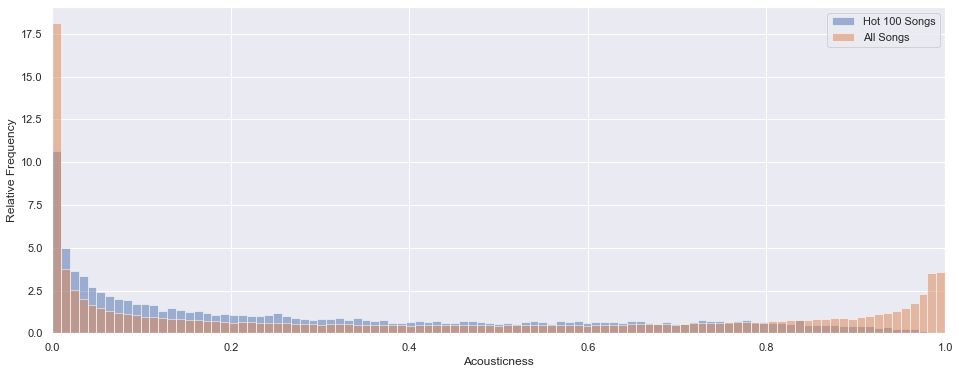

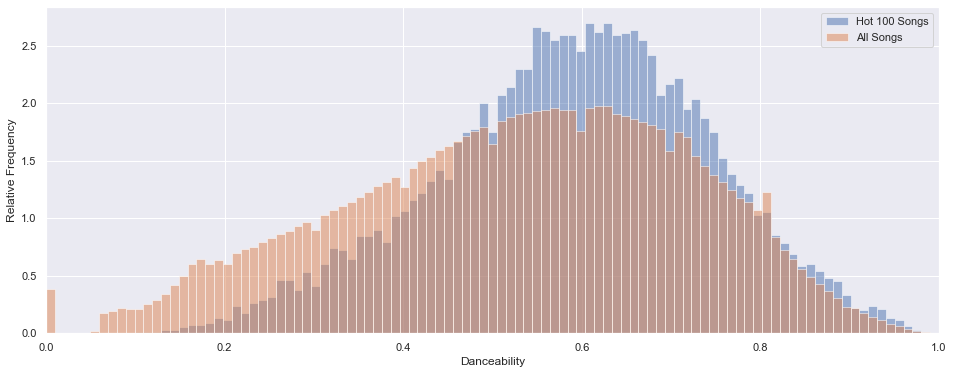

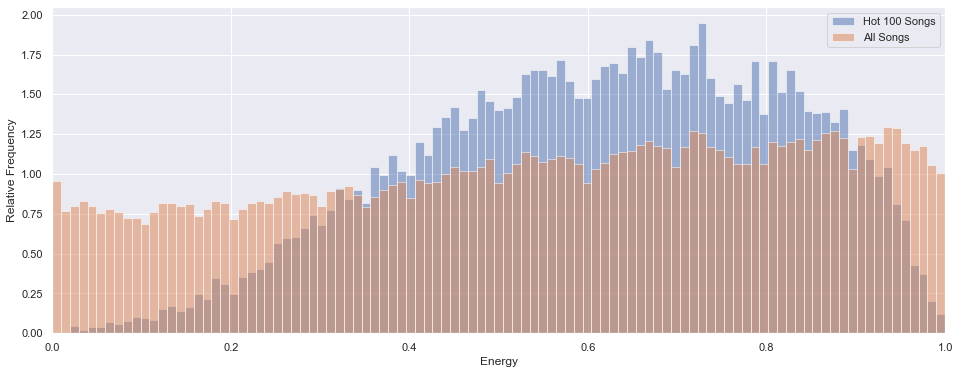

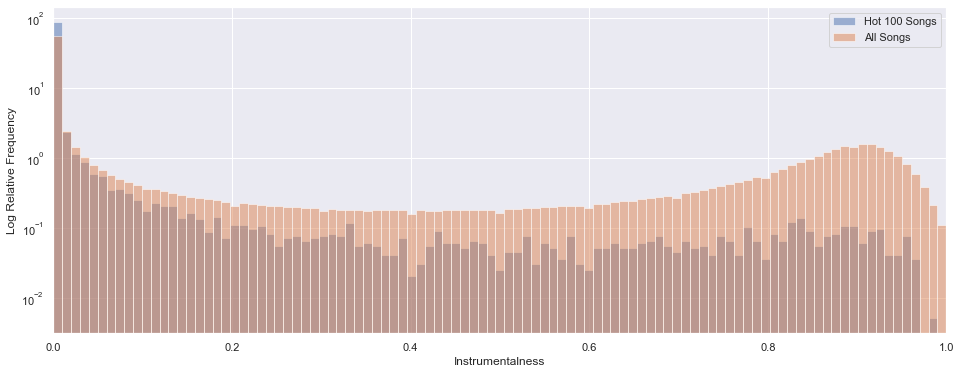

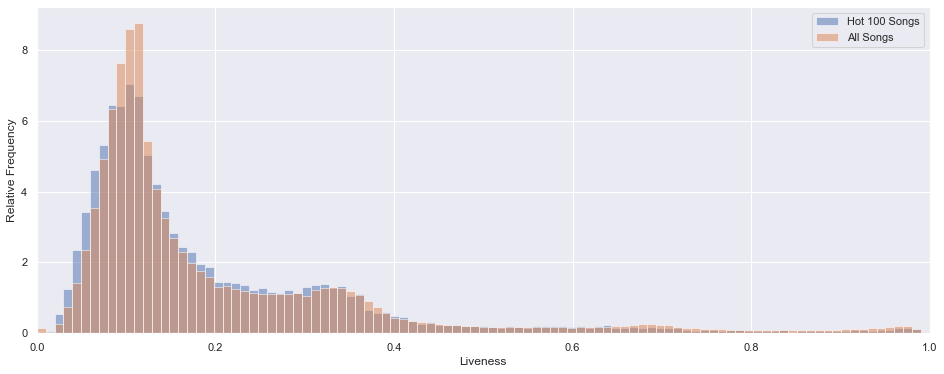

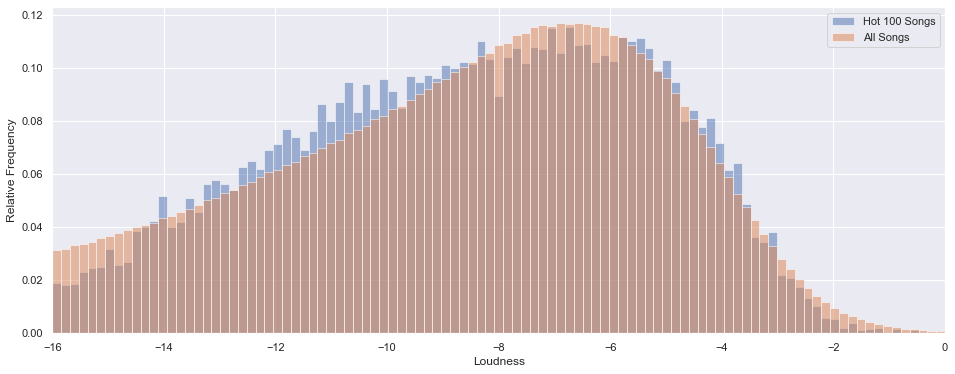

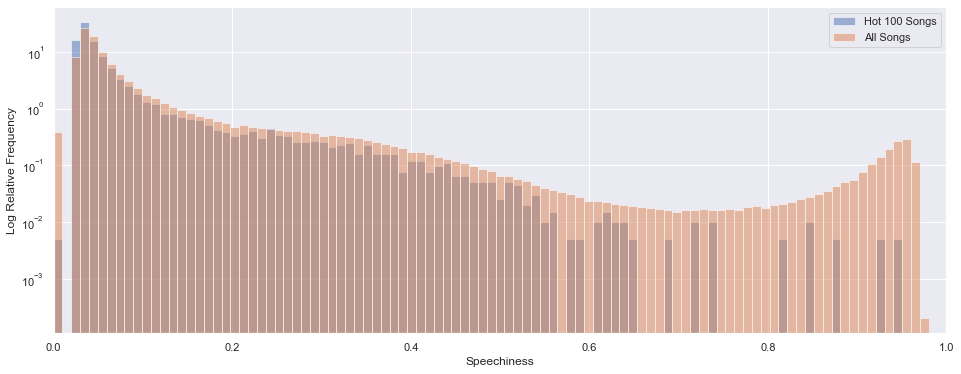

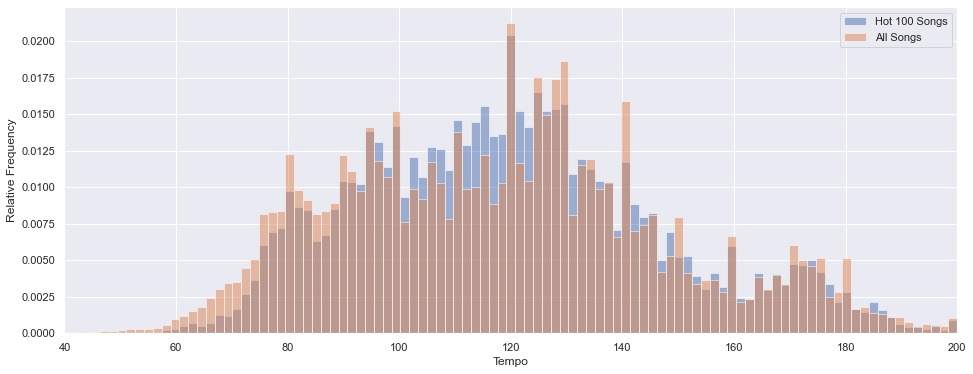

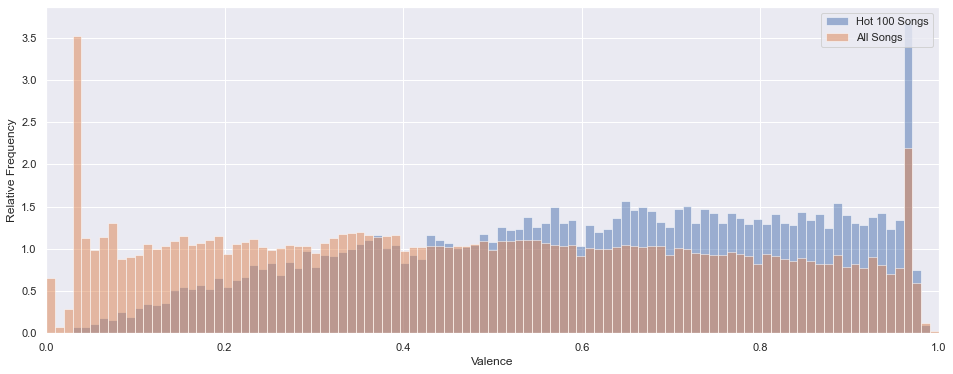

In [20]:
# Histograms of Features
for feature in features:
    compare_histograms(feature, 100, logy=(feature in ['duration_ms', 'instrumentalness', 'speechiness']))

In [21]:
# features requiring specific bin sizes
other_features = ['key', 'mode', 'time_signature']

# Histograms of Features with Specific Bin Sizes
other_bins = {'key': 12, 'mode': 2, 'time_signature': 5}

def compare_histograms_discrete(feature, bins=50, logy=False, figsize=(16, 6)):

    fig, ax = plt.subplots(figsize=figsize)
    
    # use range(bins+1) to offset tick labels and line up with appropriate labels
    plt.hist(df_B100_songs_AF[feature], [x for x in range(bins+1)], alpha=0.5, label='Hot 100 Songs', density=True, align='left')
    plt.hist(df_10M[feature], [x for x in range(bins+1)], alpha=0.5, label='All Songs', density=True, align='left')

    title = f'{feature.title()} Histogram'
#     plt.title(title)
    plt.xlabel(feature.title().replace('_', ' '))
    plt.legend(loc='upper right')
    if logy:
        plt.yscale('log')
        plt.ylabel('Log Relative Frequency')
    else:
        plt.ylabel('Relative Frequency')
    
    ax.set(xticks=[x for x in range(bins)])
    
    # save the image
    plt.savefig(f'figures/histograms/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')
    
    plt.show()


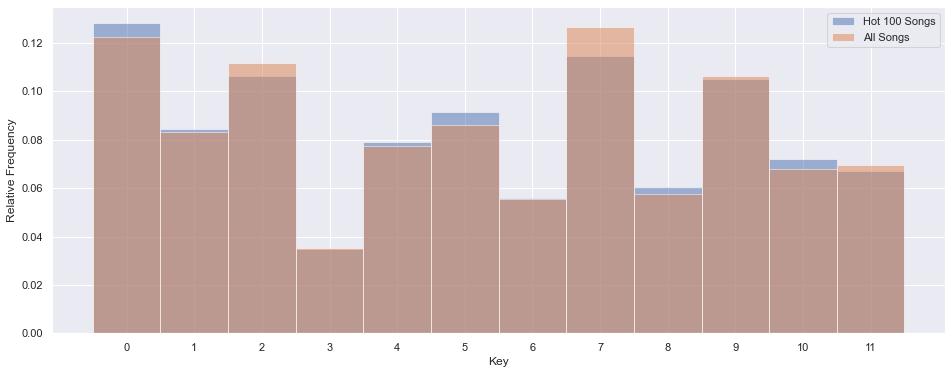

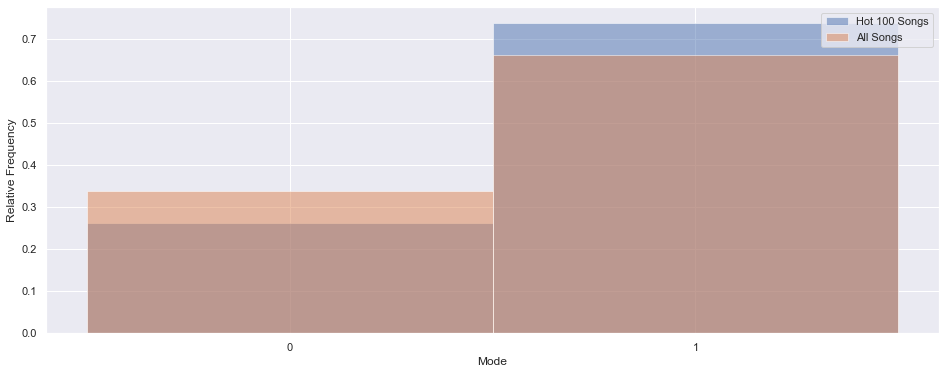

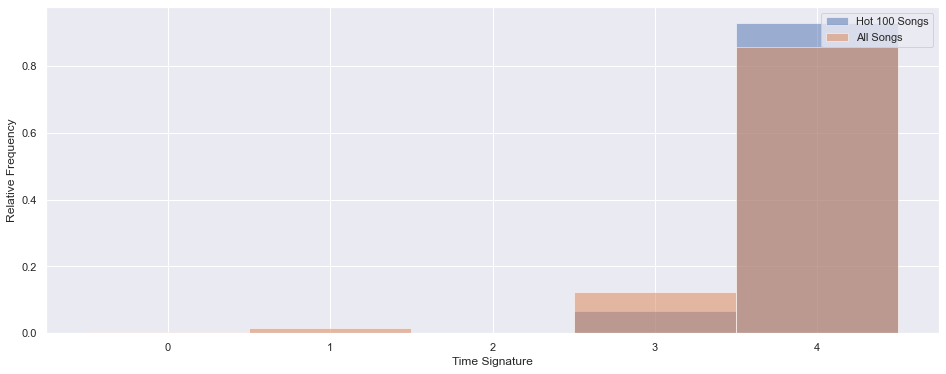

In [22]:
# Histograms of Features with Specific Bin Sizes

# Histograms of Features
for feature in other_features:
    compare_histograms_discrete(feature, other_bins[feature])

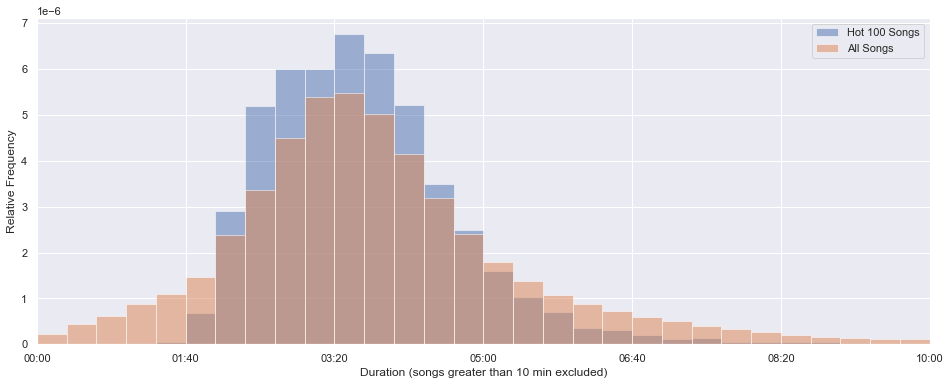

In [23]:
# duration_ms needs to share the x-axis

fig, ax = plt.subplots(figsize=(16, 6))

bins = 1000
maxx = df_10M['duration_ms'].max()
maxx = round(maxx, ndigits=-7)
increment = maxx / bins  # need to do this first or get integer wrap around error
bins = [x for x in range(bins) * increment] 

plt.hist(df_B100_songs_AF['duration_ms'], bins, alpha=0.5, label='Hot 100 Songs', density=True)
plt.hist(df_10M['duration_ms'], bins, alpha=0.5, label='All Songs', density=True)

title = 'Duration Histogram'
# plt.title(title)
plt.xlabel('Duration (songs greater than 10 min excluded)')
plt.legend(loc='upper right')
plt.ylabel('Relative Frequency')
ax.set_xlim((0, 600000))

# https://stackoverflow.com/questions/40395227/minute-and-second-format-for-x-label-of-matplotlib
formatter = mpl.ticker.FuncFormatter(lambda ms, x: time.strftime('%M:%S', time.gmtime(ms // 1000)))
ax.xaxis.set_major_formatter(formatter)

# save the image
plt.savefig(f'figures/histograms/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

plt.show(feature.title())

# Time Series

In [26]:
# audio features
main_features = [
    'acousticness', 'danceability', 'energy', 'instrumentalness', 
    'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence'
]

# date filter: this affects all time series plotting functions below
# date_filter = 'release_date >= 1958'  # original filter, revised based on later section (see note below)
date_filter = '1958 <= release_date < 2021'

##### NOTE:
* The revised date_filter is based on data quality past 2020
* this is based on analysis later in this notebook: Time Series Counts - Preferred Date Filter
    * this analysis is later in the notebook because it was conducted to explain abberations in time series plots

In [55]:
def plot_attribute_history(feature, dataframe=df_B100_songs_AF, title=None, colour=0):
    """
    Uses songs df_B100_songs_AF by default
    Plots Billboard Hot 100 audio features over time
    """
    # drop values before billboard 100 (lower quality data)
    temp_df = dataframe.query(date_filter)

    plt.figure(figsize=(16, 6))
    ax = sns.lineplot(
        x=temp_df.release_date.dt.year, 
        y=temp_df[feature],
        color=sns.color_palette()[colour], 
        errorbar=('pi', 50)  # middle 50% or IQR
    )
    
    if title:
        title=title
    else:
        title=f'{feature.capitalize()} History in the Billboard Hot 100, Aggregated By Release Year, Interquartile Range Highlighted'
    
    if feature == 'loudness':
        plt.ylim(-16, 0)  # reasonable range for loudness in music
    elif feature == 'tempo':
        plt.ylim(40, 200)  # reasonable range for tempo in music
    else:
        plt.ylim(0, 1)  # most audio features vary between 0 and 1
        # NOTE: mode is an int, either 0 or 1 (minor/major), 
        # but the average shows how commonly a song is in either mode
    
    plt.title(title, fontsize=13)
    plt.xlabel('Year of Release')
    plt.ylabel(feature.capitalize().replace('_', ' '))
    
    # save the image
    plt.savefig(f'figures/timeseries/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')
    
    plt.show()

# # test
# plot_attribute_history('acousticness')

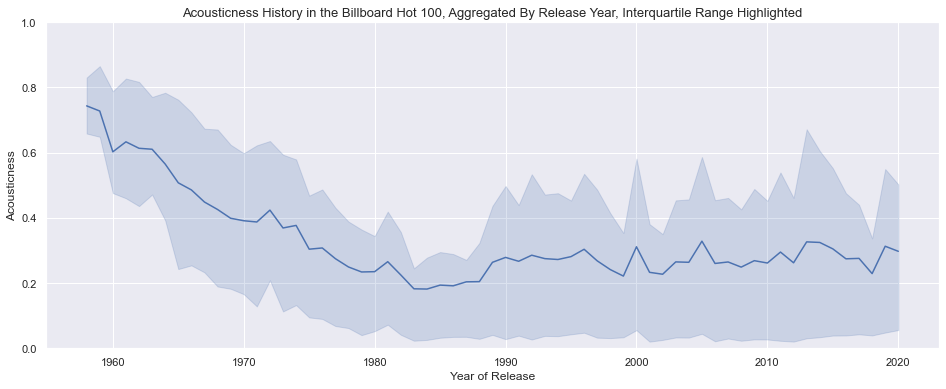

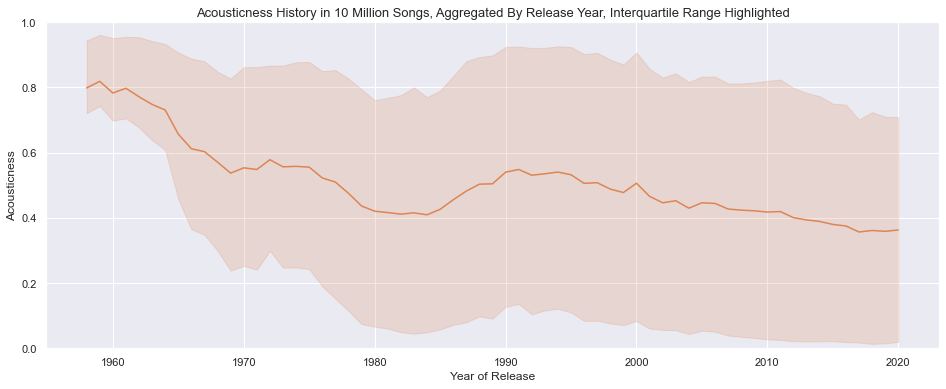

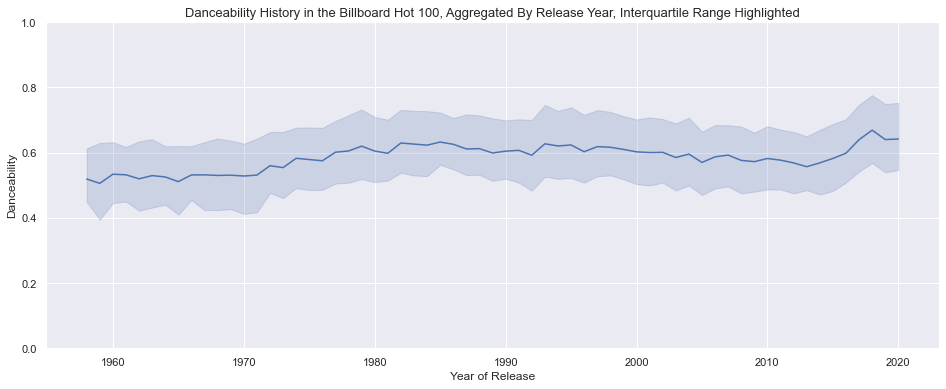

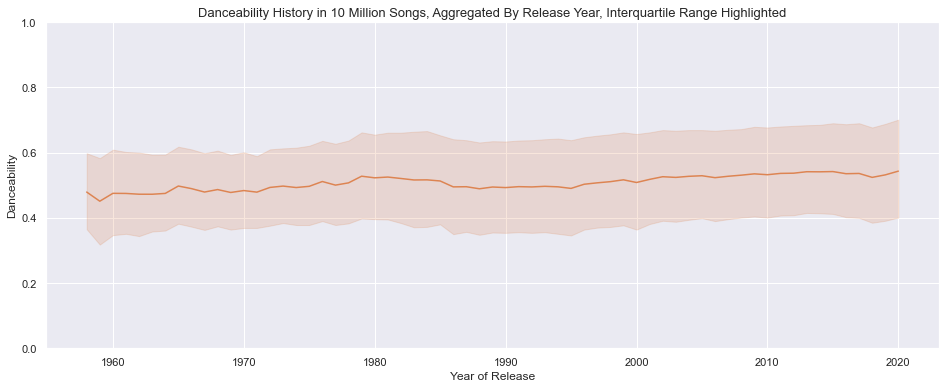

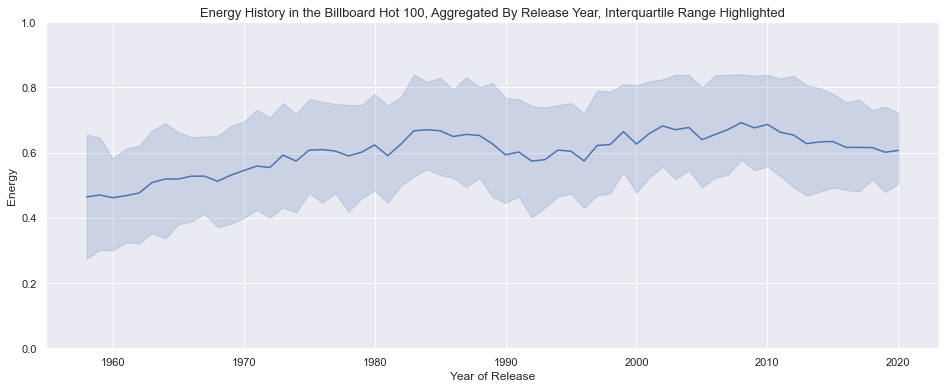

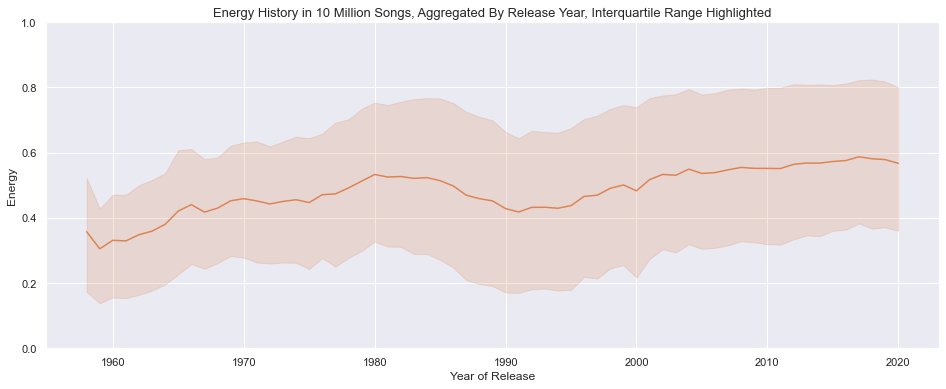

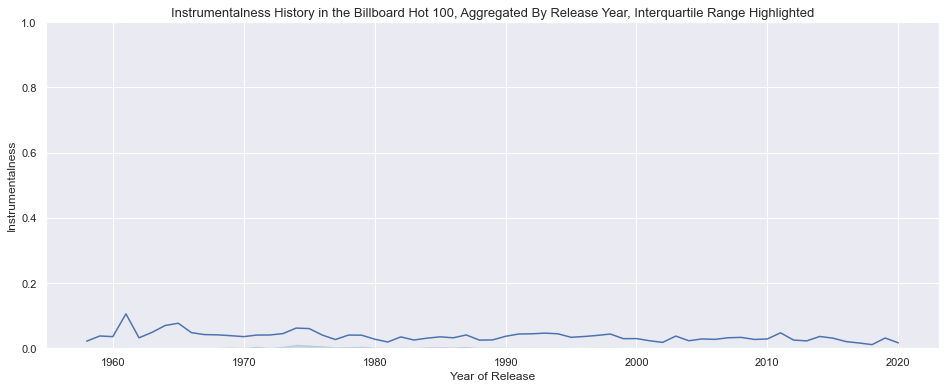

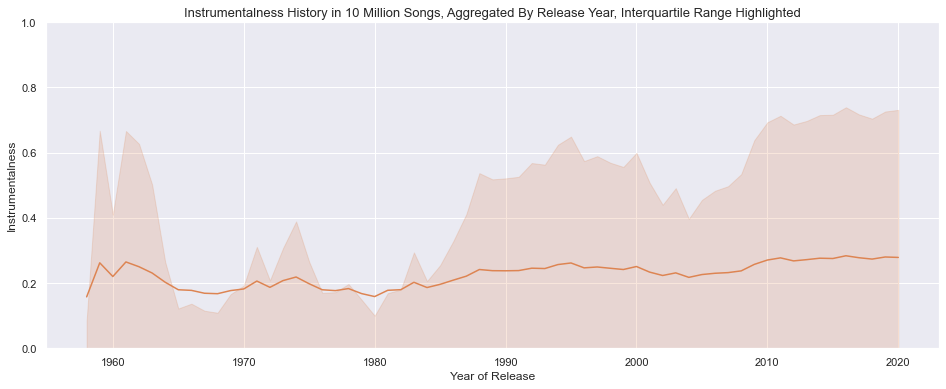

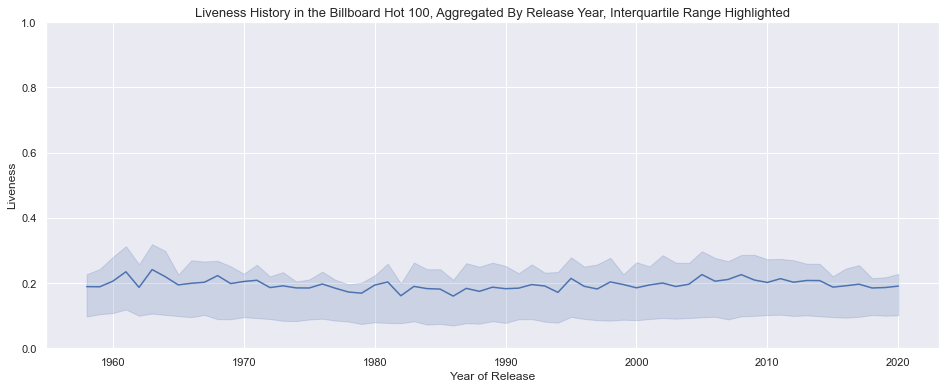

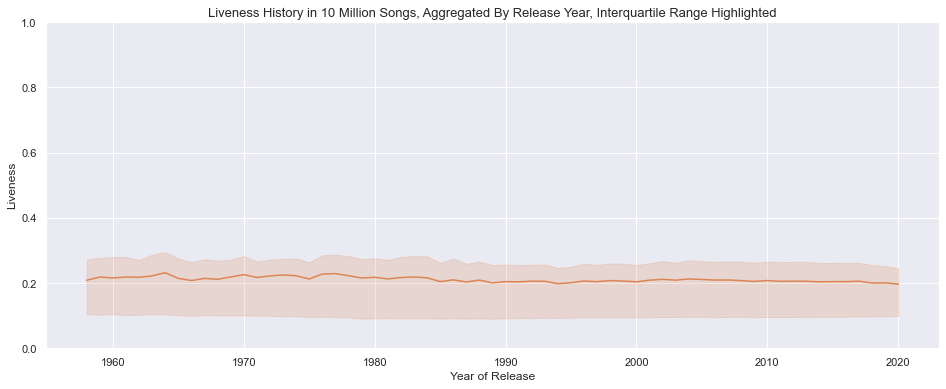

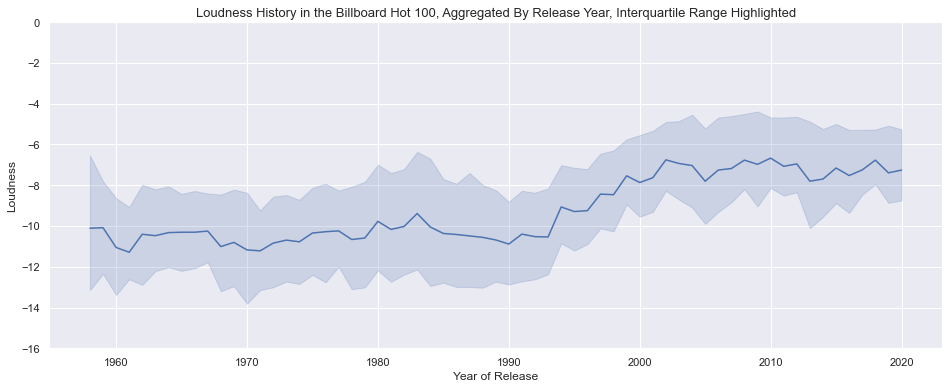

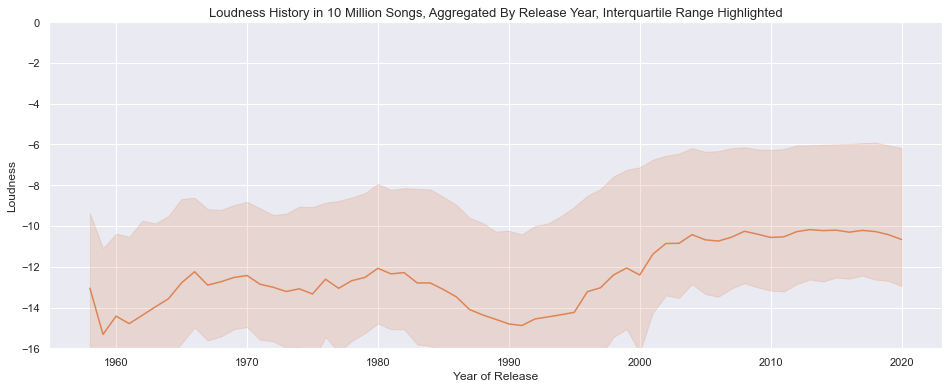

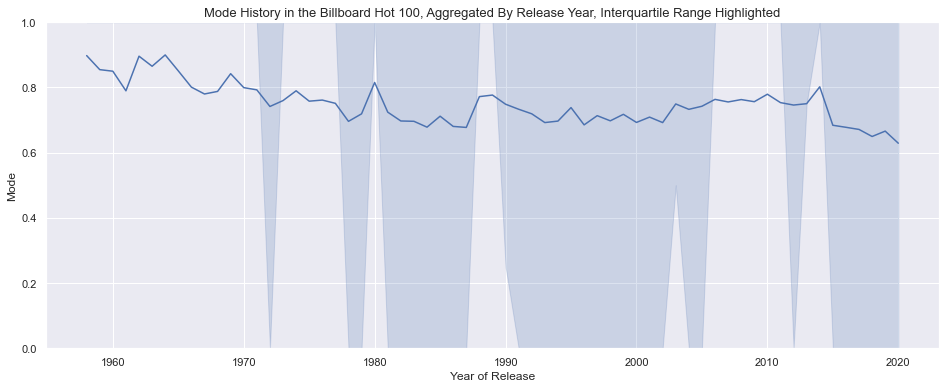

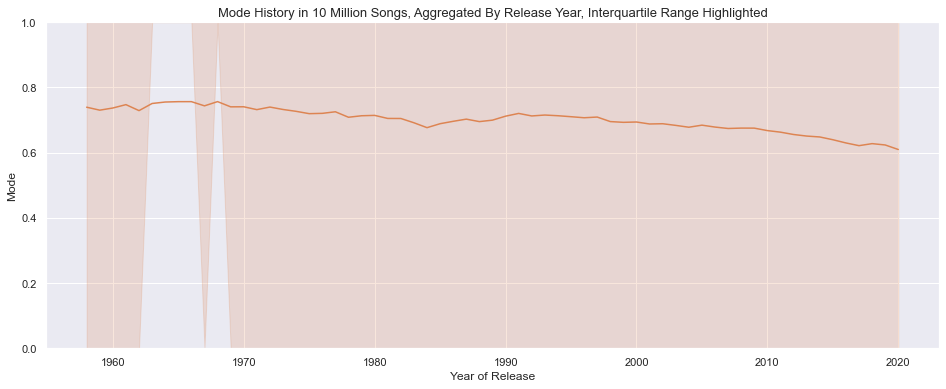

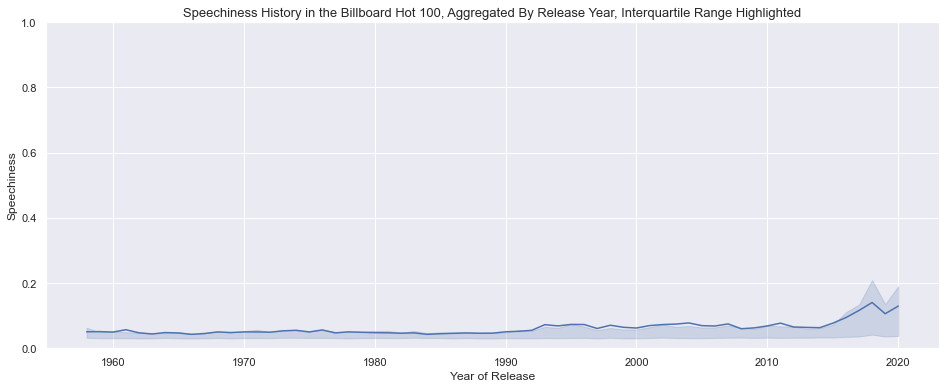

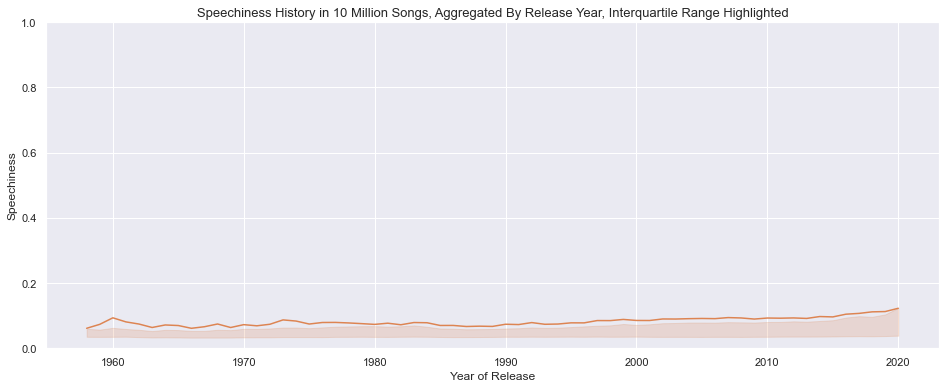

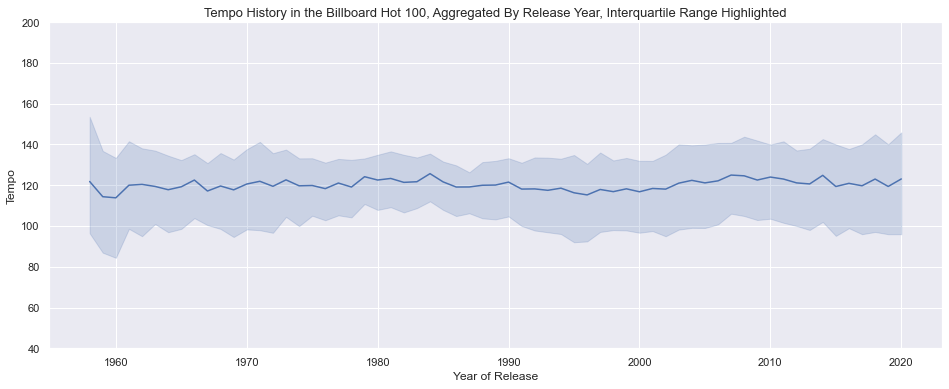

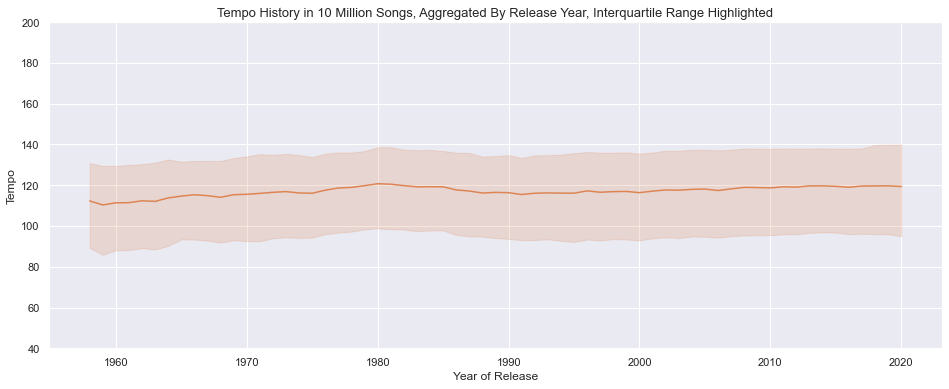

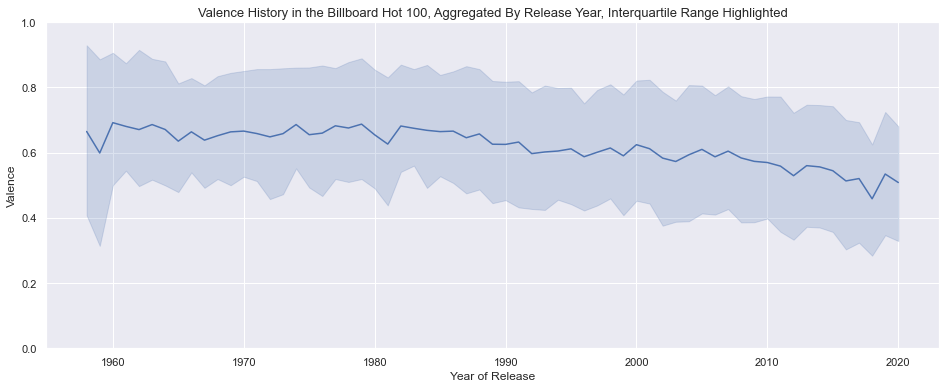

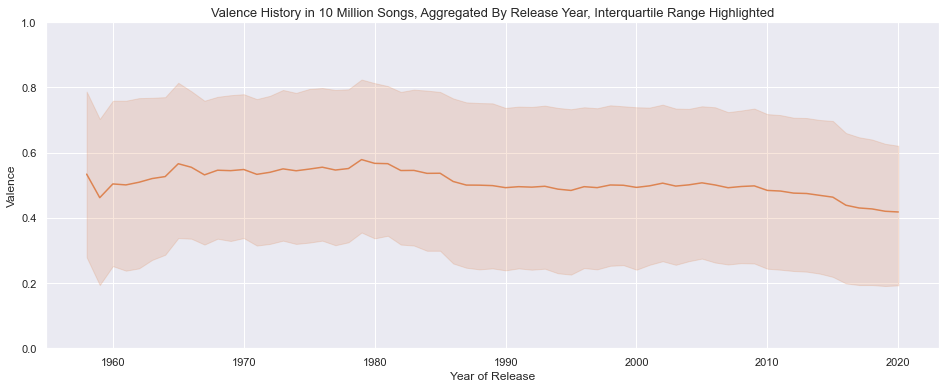

Wall time: 1min 18s


In [57]:
%%time
# plot features for Billboard Hot 100 and All Songs
for feature in main_features:
    # first plot the Billboard Hot 100
    plot_attribute_history(feature)
    # then plot the same feature from the large dataset
    title = f'{feature.capitalize()} History in 10 Million Songs, Aggregated By Release Year, Interquartile Range Highlighted'
    plot_attribute_history(feature, dataframe=df_10M, title=title, colour=1)

In [58]:
# audio features
other_features = [
    'key', 'time_signature', # integers don't make sense in timeseries lineplot (maybe heatplot?)
    'duration_ms',  # irregular feature, plotting requires some extra work
]

def plot_duration(feature='duration_ms', dataframe=df_B100_songs_AF, title=None, colour=0):
    """
    Uses songs df_B100_songs_AF 
    Plots Billboard Hot 100 audio features over time
    """
    # drop values before billboard 100 (lower quality data)
    temp_df = dataframe.query(date_filter)
    
    plt.figure(figsize=(16, 6))
    ax = sns.lineplot(
        x=temp_df.release_date.dt.year, 
        y=temp_df[feature],
        color=sns.color_palette()[colour], 
        errorbar=('pi', 50)  # middle 50% or IQR
    )
    
    formatter = mpl.ticker.FuncFormatter(lambda ms, x: time.strftime('%M:%S', time.gmtime(ms // 1000)))
    ax.yaxis.set_major_formatter(formatter)
    plt.ylabel('Duration (minutes : seconds)')
        
    if title:
        title=title
    else:
        title=f'Song Duration History in the Billboard Hot 100, Aggregated By Release Year, Interquartile Range Highlighted'
    
    plt.ylim(120000, 300000)  # reasonable range for duration of music
    
    plt.title(title, fontsize=13)
    
    # save the image
    plt.savefig(f'figures/timeseries/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')
    
    plt.show()


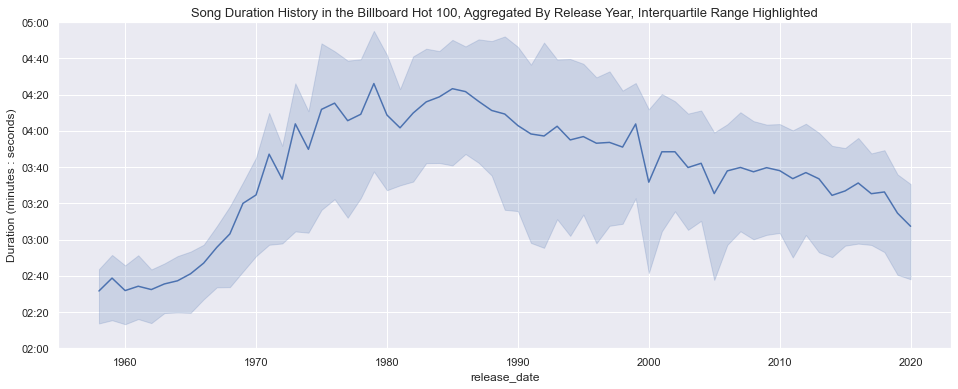

In [59]:
plot_duration(feature='duration_ms')

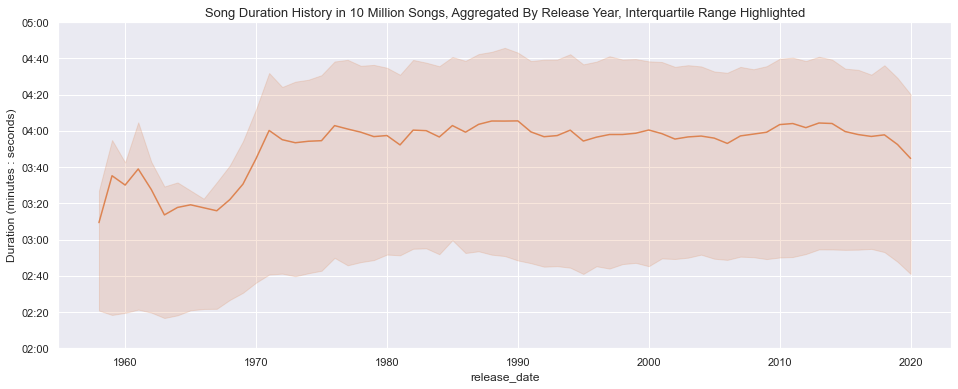

Wall time: 12.2 s


In [60]:
%%time
title = 'Song Duration History in 10 Million Songs, Aggregated By Release Year, Interquartile Range Highlighted'
plot_duration(feature='duration_ms', dataframe=df_10M, title=title, colour=1)

### Comparative Time Series

In [27]:
def plot_feature_comparison(feature):
    """
    Uses songs df_B100_songs_AF 
    Plots Billboard Hot 100 audio features over time
    """
    
    fig, ax = plt.subplots(figsize=(16, 6))
    
    df1 = df_B100_songs_AF.query(date_filter)
    ax = sns.lineplot(
        x=df1.release_date.dt.year, 
        y=df1[feature],
        color=sns.color_palette()[0], 
        errorbar=None, 
        label='Hot 100 Songs'
    )
    
    df2 = df_10M.query(date_filter)
    ax = sns.lineplot(
        x=df2.release_date.dt.year, 
        y=df2[feature],
        color=sns.color_palette()[1], 
        errorbar=None, 
        label='All Songs'
    )
    
    title=f'{feature.capitalize()} History Comparing the Billboard Hot 100 with All Songs'
            
    if feature == 'loudness':
        plt.ylim(-16, 0)  # reasonable range for loudness in music
    elif feature == 'tempo':
        plt.ylim(40, 200)  # reasonable range for tempo in music
    else:
        plt.ylim(0, 1)  # most audio features vary between 0 and 1
        # NOTE: mode is an int, either 0 or 1 (minor/major), 
        # but the average shows how commonly a song is in either mode
    
#     plt.title(title, fontsize=13)
    plt.xlabel('Year of Release')
    plt.ylabel(feature.capitalize().replace('_', ' '))
    plt.legend(loc='upper right')
    
    # save the image
    plt.savefig(f'figures/timeseries/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')
    
    plt.show()


def plot_duration_comparison(feature='duration_ms'):
    """
    Uses songs df_B100_songs_AF 
    Plots Billboard Hot 100 audio features over time
    """
    
    fig, ax = plt.subplots(figsize=(16, 6))
    
    df1 = df_B100_songs_AF.query(date_filter)
    ax = sns.lineplot(
        x=df1.release_date.dt.year, 
        y=df1[feature],
        color=sns.color_palette()[0], 
        errorbar=None, 
        label='Hot 100 Songs'
    )
    
    df2 = df_10M.query(date_filter)
    ax = sns.lineplot(
        x=df2.release_date.dt.year, 
        y=df2[feature],
        color=sns.color_palette()[1], 
        errorbar=None, 
        label='All Songs'
    )
    
    formatter = mpl.ticker.FuncFormatter(lambda ms, x: time.strftime('%M:%S', time.gmtime(ms // 1000)))
    ax.yaxis.set_major_formatter(formatter)
    plt.ylabel('Duration (minutes : seconds)')
        
    title='Song Duration History Comparing the Billboard Hot 100 with All Songs'
    
    plt.ylim(120000, 300000)  # reasonable range for duration of music
    
#     plt.title(title, fontsize=13)
    plt.xlabel('Year of Release')
    plt.legend(loc='upper right')
    
    # save the image
    plt.savefig(f'figures/timeseries/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')
    
    plt.show()


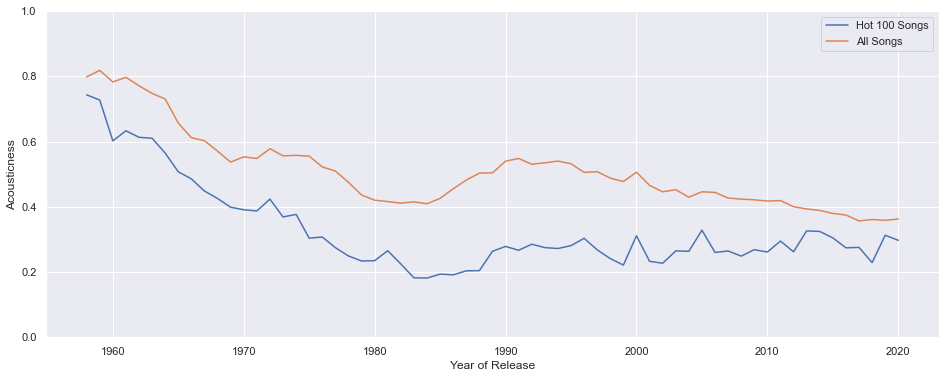

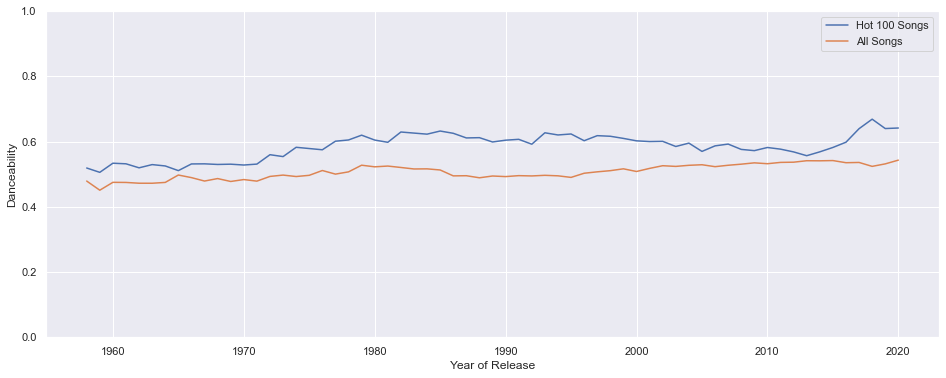

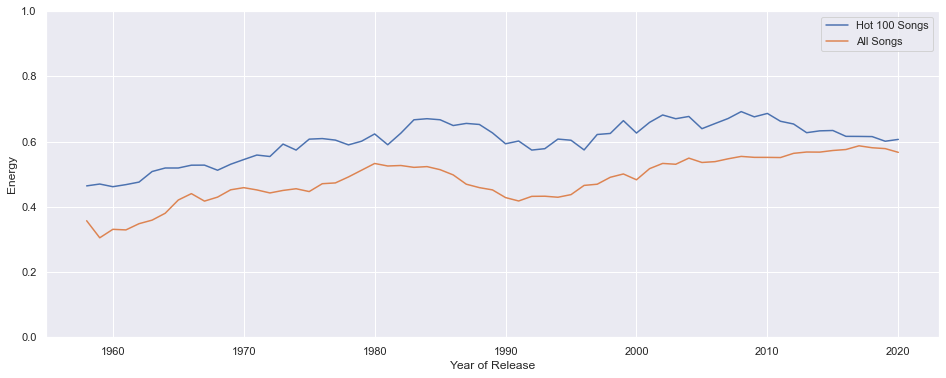

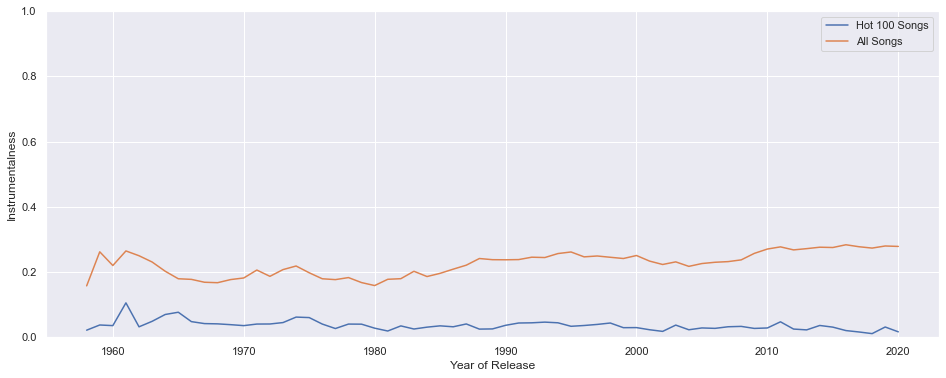

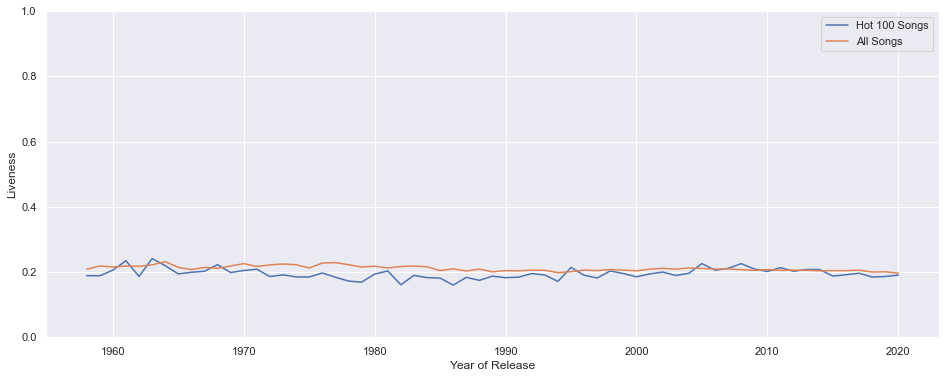

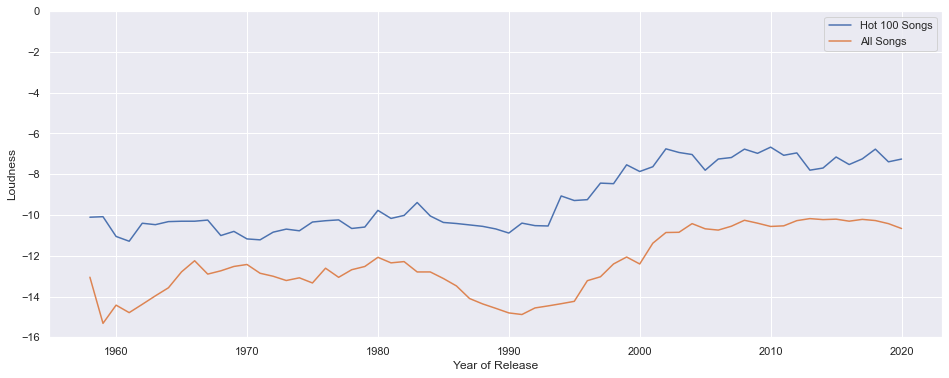

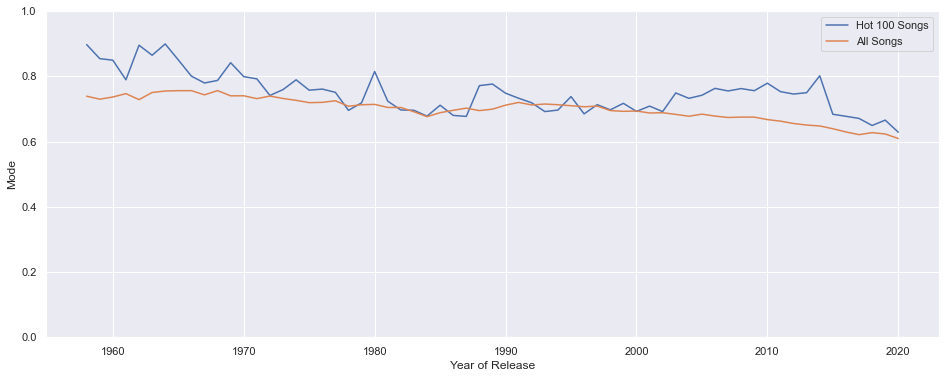

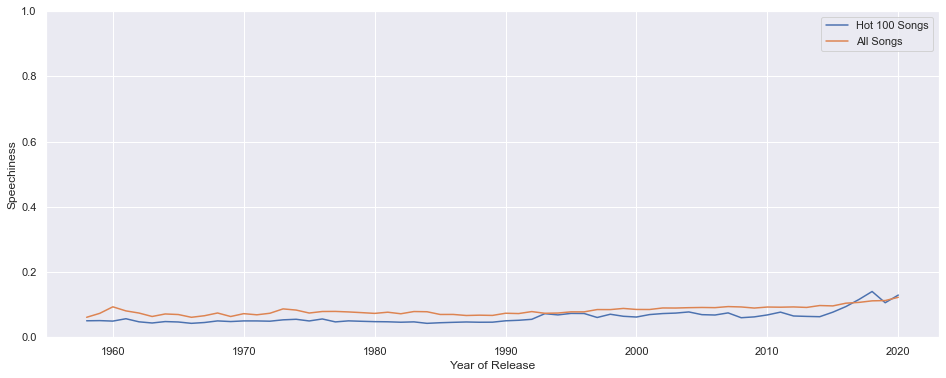

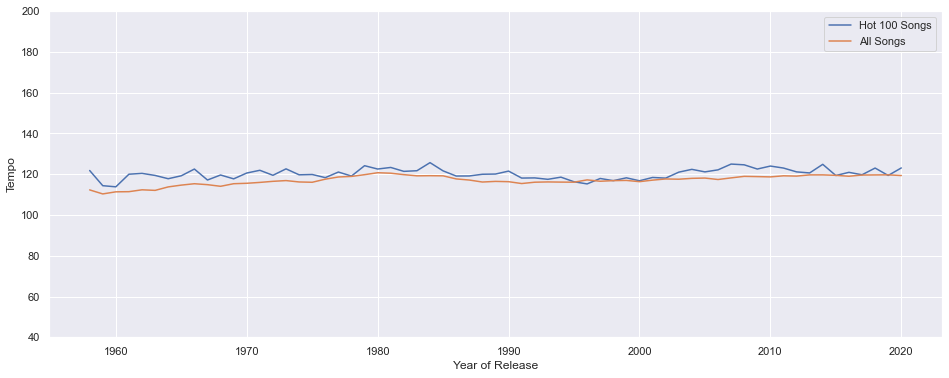

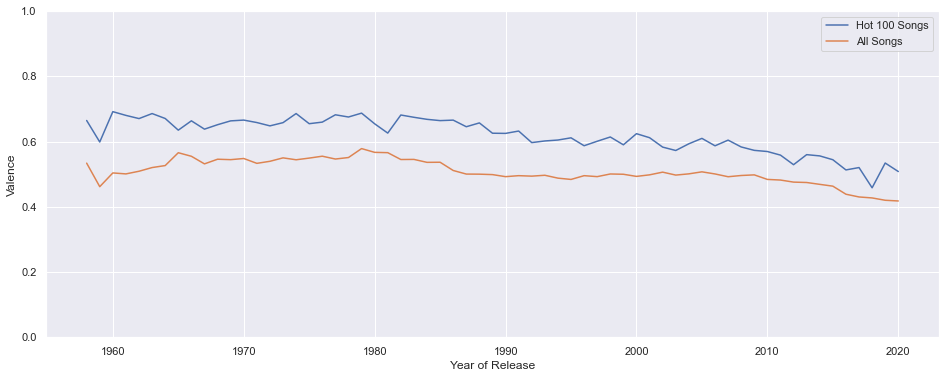

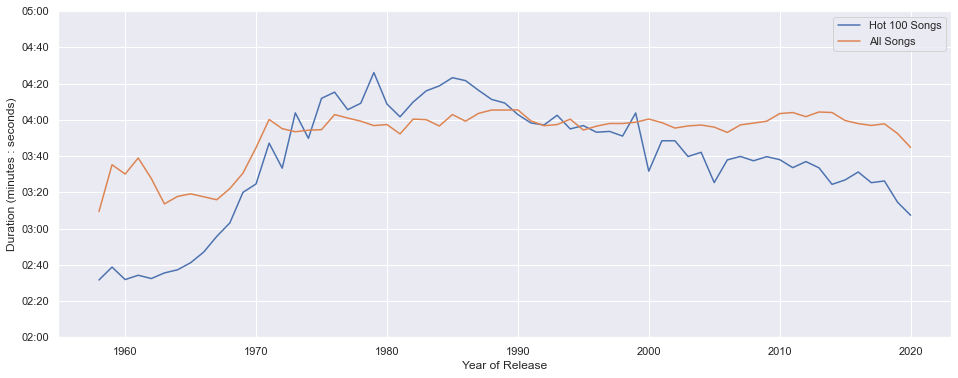

Wall time: 1min 22s


In [28]:
%%time
# audio features
main_features = [
    'acousticness', 'danceability', 'energy', 'instrumentalness', 
    'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence'
]

for feature in main_features:
    plot_feature_comparison(feature)
plot_duration_comparison()

### Time Series Counts - Preferred Date Filter
* data seems to deteriorate after 2020, with large movements in music trends (CORRECT)
* alternatively, this could be due to significant societal changes and preferences (NOT VERIFIABLE)
##### Let's find out!

In [30]:
df_10M.release_date.dt.year.value_counts().reset_index().sort_values('index', ascending=False).head()

index  release_date
67 2022.000            68
27 2021.000         84478
9  2020.000        359973
11 2019.000        329738
12 2018.000        321232

In [31]:
df_B100_songs.release_date.dt.year.value_counts().reset_index().sort_values('index', ascending=False).head()

index  release_date
63 2022.000           112
17 2021.000           419
0  2020.000           648
7  2019.000           494
8  2018.000           493

In [32]:
# find max dates for each dataset

# SQL
max_date_sql = 1644537600000
pd.to_datetime(max_date_sql, unit='ms', origin='unix')

Timestamp('2022-02-11 00:00:00')

In [36]:
# Billboard Hot 100
df_B100.sort_values('date', ascending=False).head(1)['date']

329929   2021-11-06
Name: date, dtype: datetime64[ns]

In [42]:
# CSV
pd.read_csv('D:/RYERSON/820/Datasets/Spotify 1.2M+ Songs/tracks_features.csv').sort_values('release_date', ascending=False).head(1)['release_date']

1134062    2020-12-18
Name: release_date, dtype: object

In [48]:
# Latest Release Dates by Dataset
latest_sql = pd.to_datetime('2022-02-11 00:00:00')
latest_B100 = pd.to_datetime('2021-11-06 00:00:00')
latest_csv = pd.to_datetime('2020-12-18 00:00:00')

# max date option 1 (all datasets consistent):
maxdate_1 = min(latest_sql, latest_B100, latest_csv)

# max date option 2 (all Billboard 100 songs):
maxdate_2 = min(latest_sql, latest_B100)

# options for filtering
maxdate_1, maxdate_2

(Timestamp('2020-12-18 00:00:00'), Timestamp('2021-11-06 00:00:00'))

In [51]:
# let's check the quantiy (not quality) of 2021 (with SQL, without CSV) vs 2020 (both)

df_10M.query('2021 <= release_date < 2022').shape[0], df_10M.query('2020 <= release_date < 2021').shape[0]

(84478, 359973)

In [52]:
# only 23% of the songs during 2021 vs 2020: looks like maxdate_1 is a better choice
df_10M.query('2021 <= release_date < 2022').shape[0] / df_10M.query('2020 <= release_date < 2021').shape[0]

0.2346787120145122

##### CONCLUSION: We should only include data up to, but not including 2021

In [14]:
if []:
    print('hi')

### Billboard Charts Historical Plots

In [34]:
# audio features
normalised_features = [
    'acousticness', 'danceability', 'energy', 'instrumentalness', 
    'liveness', 'mode', 'speechiness', 'valence'
]

# features to normalise
features_to_normalise = [
    'loudness', 'tempo', 'duration_ms', 'time_signature'
]

def plot_billboard_history(normalised_features, features_to_normalise):
    """
    Uses songs df_B100
    Plots Billboard Hot 100 audio features over time
    """
    if features_to_normalise:  # if there are features to normalise
        # combine lists of features
        list_of_features = sorted([*normalised_features, *features_to_normalise])

        # create the normalised dataframe
        df = df_B100.dropna().copy()
        n = features_to_normalise  # just to shorten the next line of code
        df[[*n]] = (df[[*n]]-df[[*n]].min()) / (df[[*n]].max()-df[[*n]].min())
    else:
        list_of_features = normalised_features
        df = df_B100.dropna().copy()
    
    # create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for feature in list_of_features:
        ax = sns.lineplot(
            x=df.date.dt.year, 
            y=df[feature],
            errorbar=None,  
            linewidth=2,
            label=feature.replace('_', ' ').title()
        )
        
    title='Billboard Hot 100 Historical Charts - All Features Normalised'
        
#     plt.title(title, fontsize=13)
    plt.xlabel('Year')
    plt.ylabel('Audio Feature (Normalised)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    # save the image
    plt.savefig(f'figures/timeseries/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')
    
    plt.show()



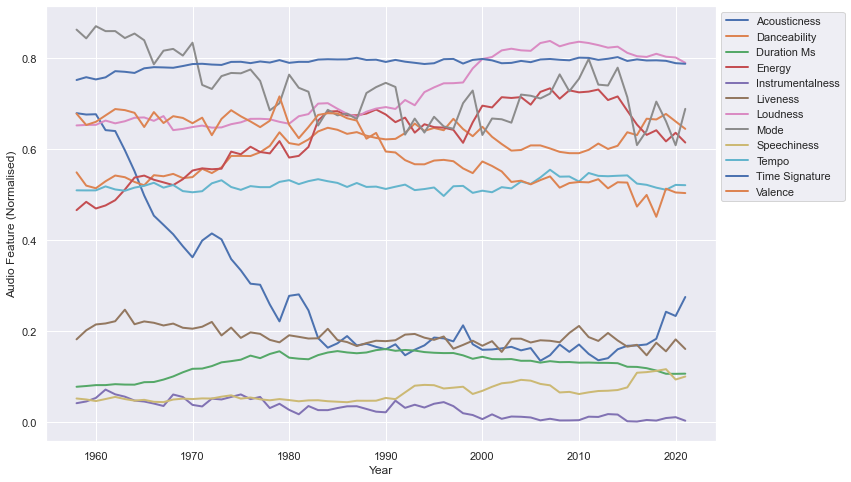

In [35]:
# plot all features historically
plot_billboard_history(normalised_features, features_to_normalise)

In [61]:
# plot individual features

def plot_billboard_history_by_feature(feature):
    """
    Uses songs df_B100
    Plots Billboard Hot 100 audio features over time
    """
    df = df_B100.dropna().copy()
    figsize=(16, 8)

    plt.figure(figsize=figsize)

    ax = sns.lineplot(
        x=df.date.dt.year, 
        y=df[feature],
        errorbar=('pi', 50),  # IQR
        linewidth=2,
        color=sns.color_palette()[2]  # different colour to differentiate with other plots
    )

    if feature == 'loudness':
        plt.ylim(-16, 0)  # reasonable range for loudness in music
    elif feature == 'tempo':
        plt.ylim(40, 200)  # reasonable range for tempo in music
    elif feature == 'time_signature':
        plt.ylim(0, 5) 
    else:
        plt.ylim(0, 1)  # most audio features vary between 0 and 1
        # NOTE: mode is an int, either 0 or 1 (minor/major), 
        # but the average shows how commonly a song is in either mode
        
    title = 'Billboard Hot 100 Historical Charts, Interquartile Range Highlighted - {}'.format(feature.replace('_', ' ').title())

    plt.title(title, fontsize=13)
    plt.xlabel('Year')
    plt.ylabel('Audio Feature')

    # save the image
    plt.savefig(f'figures/timeseries/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

    plt.show()

    
    
def plot_billboard_history_duration(feature='duration_ms'):
    
    df = df_B100.dropna().copy()
    figsize=(16, 8)
    plt.figure(figsize=figsize)

    ax = sns.lineplot(
        x=df.date.dt.year, 
        y=df[feature],
        errorbar=('pi', 50),  # IQR
        linewidth=2,
        color=sns.color_palette()[2]  # different colour to differentiate with other plots
    )

    formatter = mpl.ticker.FuncFormatter(lambda ms, x: time.strftime('%M:%S', time.gmtime(ms // 1000)))
    ax.yaxis.set_major_formatter(formatter)
    plt.ylabel('Duration (minutes : seconds)')
        
    plt.ylim(120000, 300000)  # reasonable range for duration of music
        
    title = 'Billboard Hot 100 Historical Charts, Interquartile Range Highlighted - Song Duration'

    plt.title(title, fontsize=13)
    plt.xlabel('Year')
    plt.ylabel('Audio Feature')

    # save the image
    plt.savefig(f'figures/timeseries/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

    plt.show()



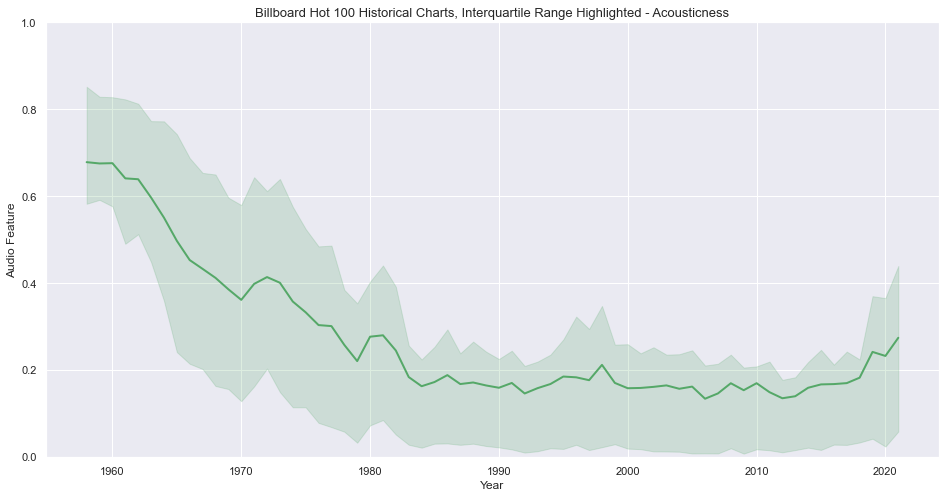

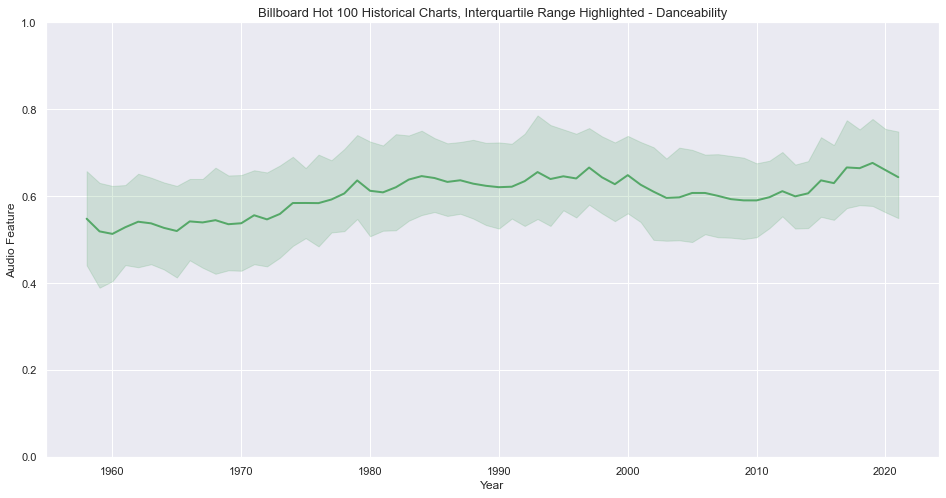

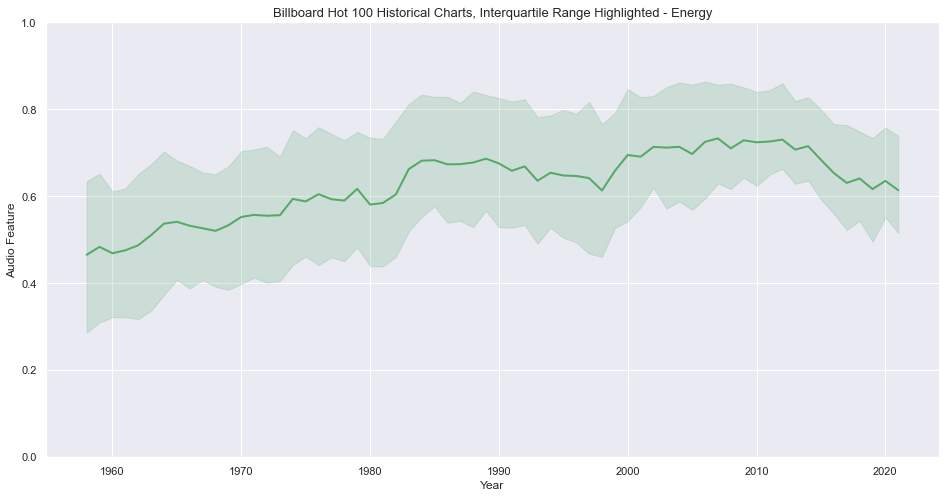

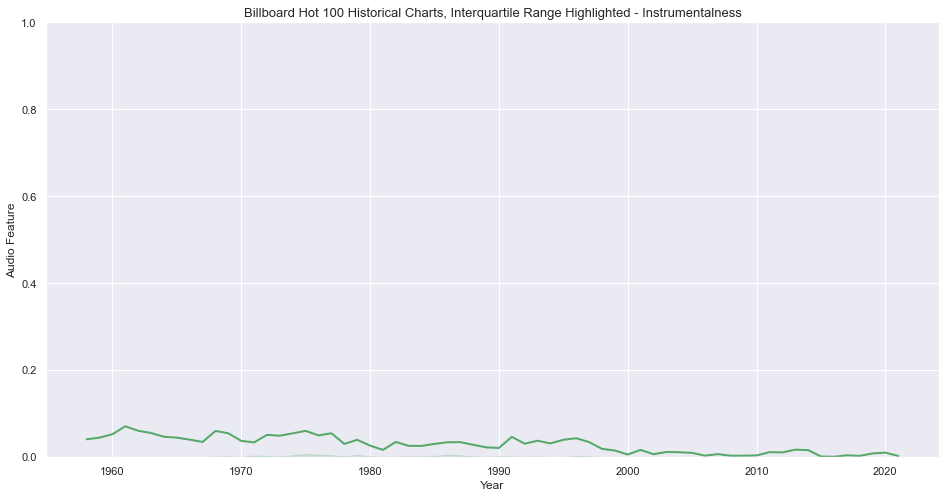

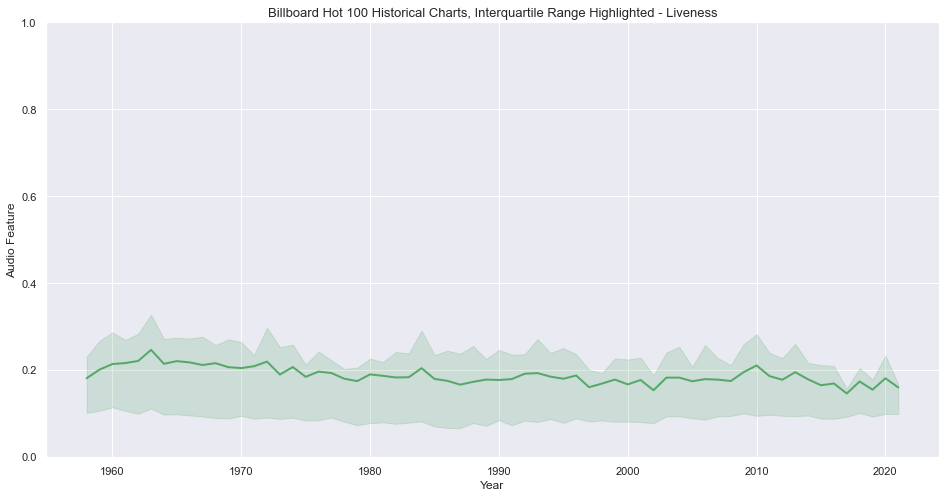

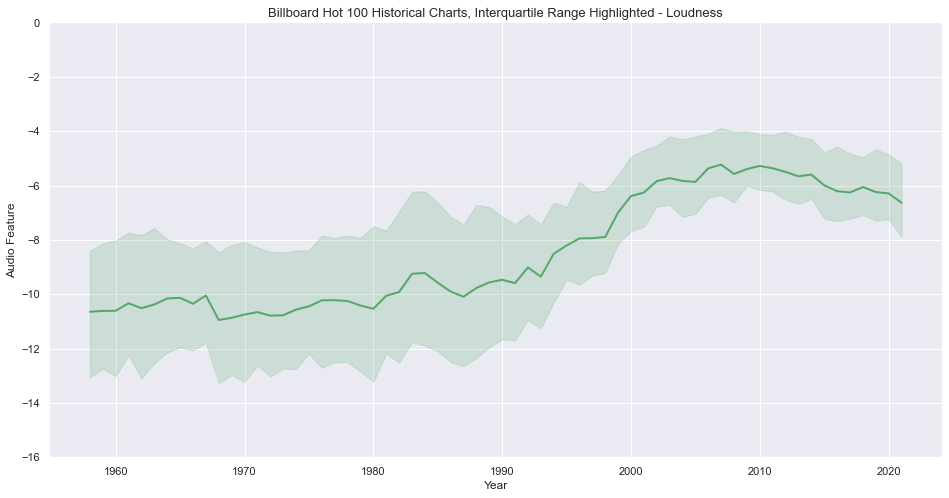

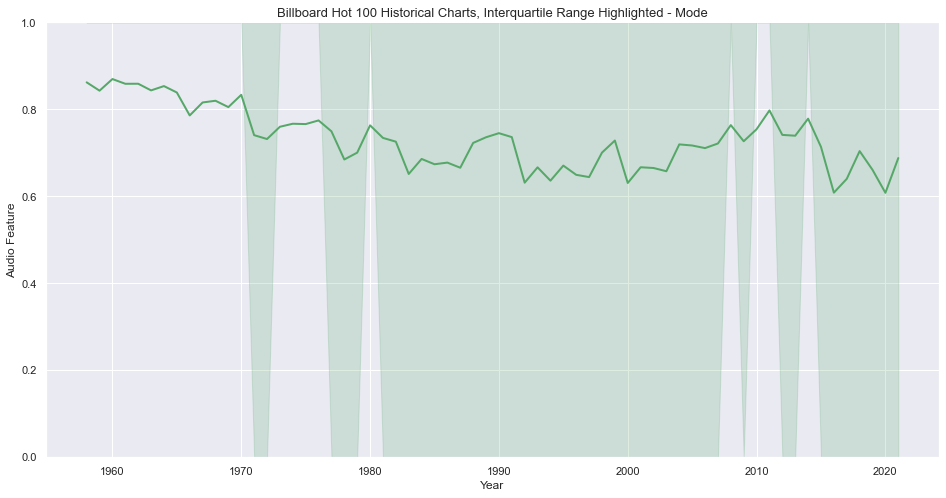

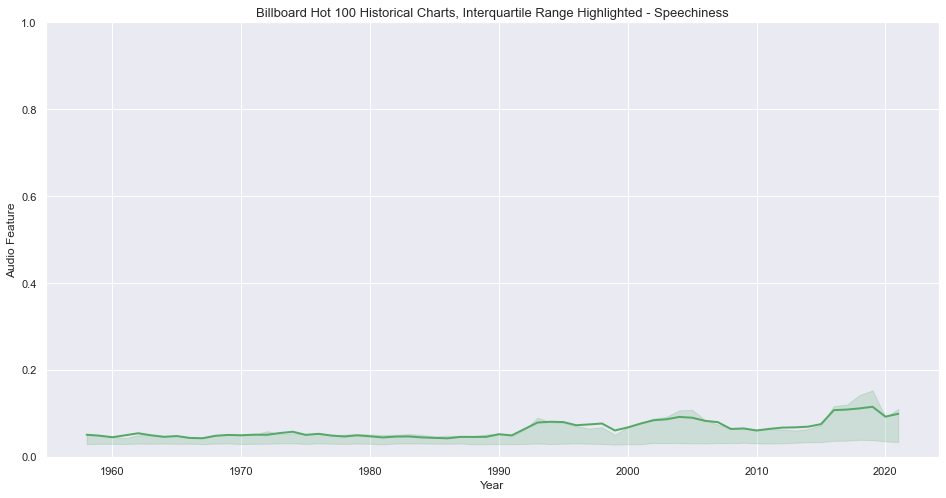

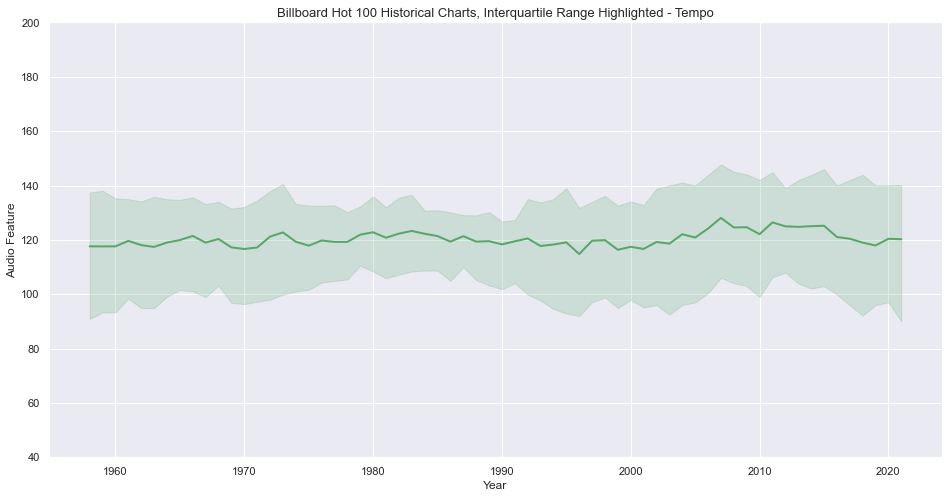

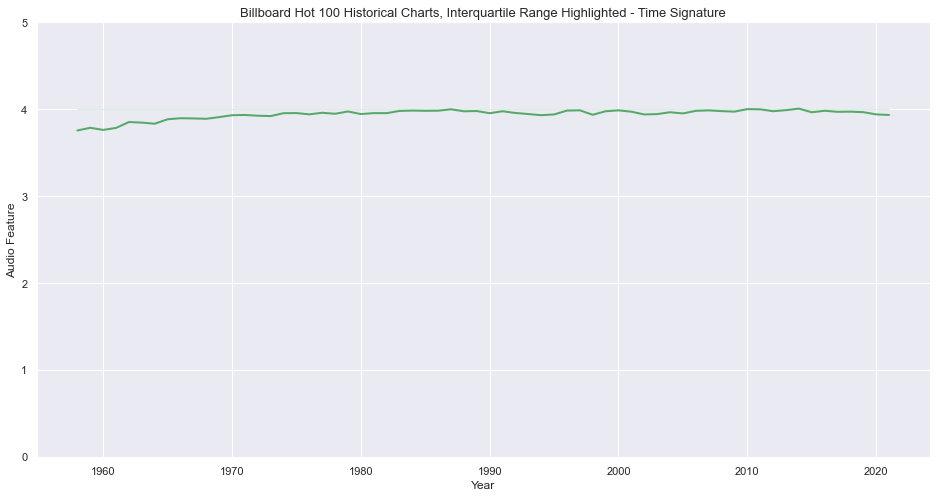

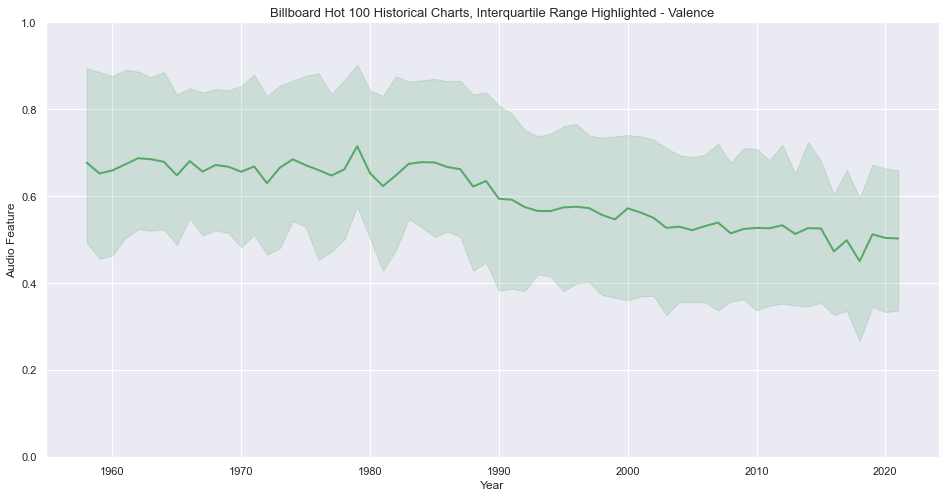

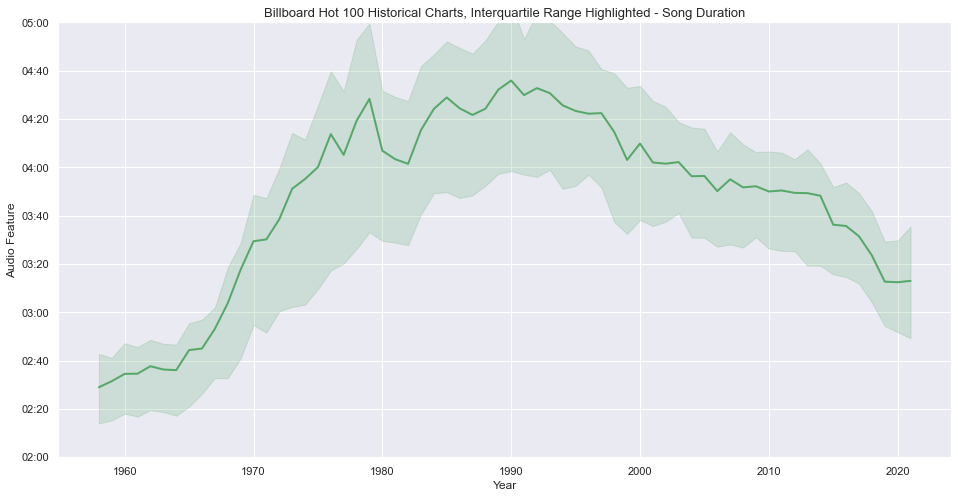

In [62]:
# make the plots
list_of_features = ['acousticness',  'danceability', 'energy', 'instrumentalness', 
                    'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']

for feature in list_of_features:
    plot_billboard_history_by_feature(feature)
    
plot_billboard_history_duration()

# Correlation Analysis

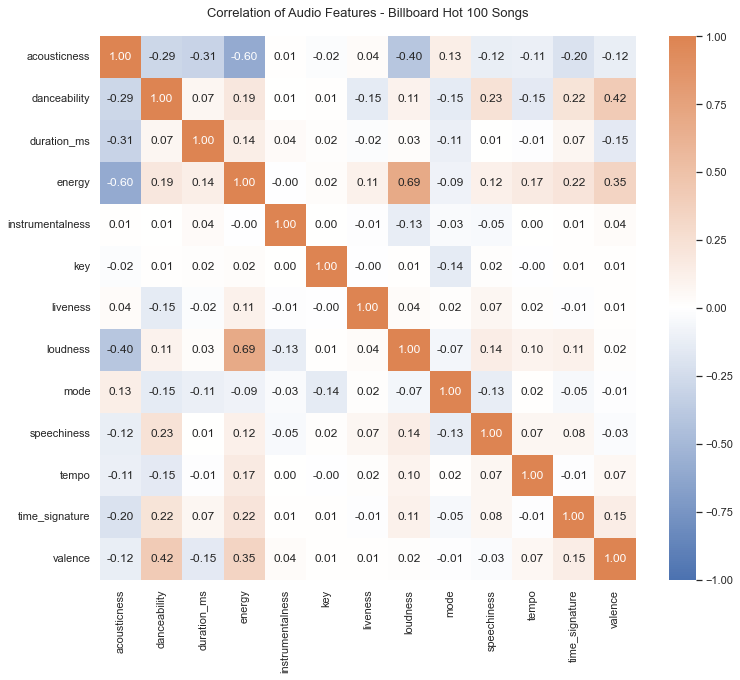

In [11]:
# correlation matrix - Billboard Hot 100
corr_B100 = df_B100_songs_AF.corr()

# plot
palette = sns.blend_palette([sns.color_palette()[0], '#ffffff', sns.color_palette()[1]], 3, as_cmap=True)
plt.subplots(figsize=(12, 10))
sns.heatmap(corr_B100, cmap=palette, center=0, vmin=-1, vmax=1, annot=True, fmt='.2f')
title='Correlation of Audio Features - Billboard Hot 100 Songs'
plt.title(title, fontsize=13, pad=20)

# save the image
plt.savefig(f'figures/correlation/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

plt.show()

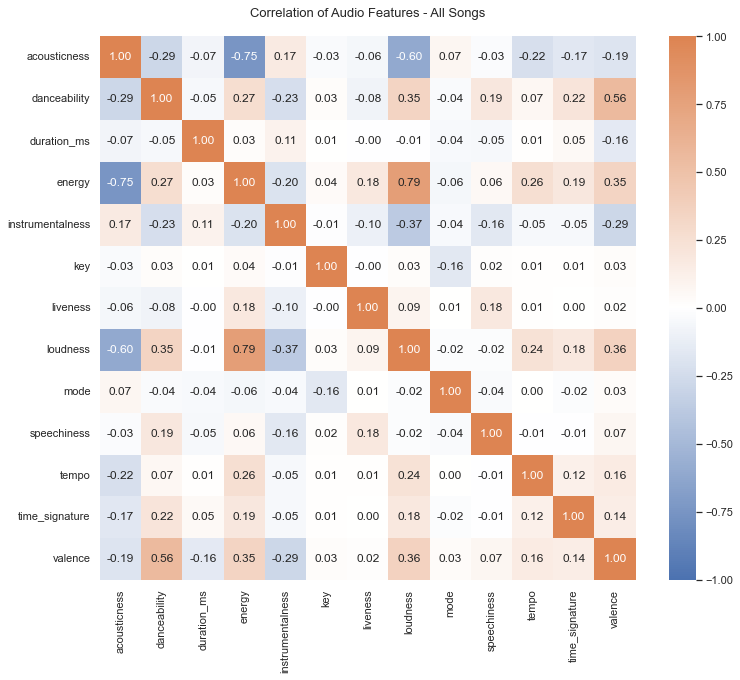

In [12]:
# correlation matrix - All Songs
corr_10M = df_10M.corr()

# plot
palette = sns.blend_palette([sns.color_palette()[0], '#ffffff', sns.color_palette()[1]], 3, as_cmap=True)
plt.subplots(figsize=(12, 10))
sns.heatmap(corr_10M, cmap=palette, center=0, vmin=-1, vmax=1, annot=True, fmt='.2f')
title='Correlation of Audio Features - All Songs'
plt.title(title, fontsize=13, pad=20)

# save the image
plt.savefig(f'figures/correlation/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

plt.show()

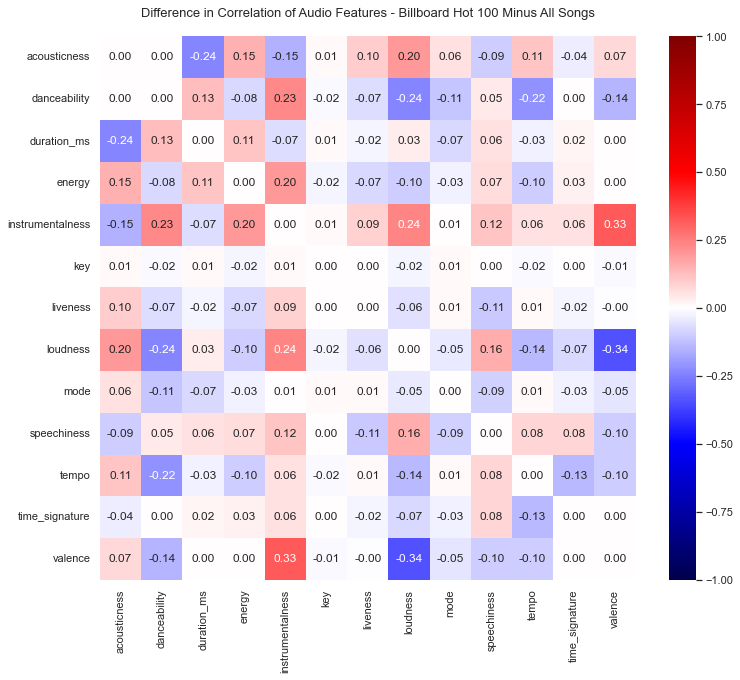

In [13]:
# differences between Billboard Hot 100 and All Songs
corr_diff = corr_B100 - corr_10M

# plot
palette = 'seismic'  # to differentiate from standard colour palette
plt.subplots(figsize=(12, 10))
sns.heatmap(corr_diff, cmap=palette, center=0, vmin=-1, vmax=1, annot=True, fmt='.2f')
title='Difference in Correlation of Audio Features - Billboard Hot 100 Minus All Songs'
plt.title(title, fontsize=13, pad=20)

# save the image
plt.savefig(f'figures/correlation/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

plt.show()

In [11]:
# Billboard 100 List - correlation with max weeks on board
df_B100_SORTED = df_B100.sort_values('weeks-on-board', ascending=False).drop_duplicates(subset=['song', 'artist']).drop(['date', 'id', 'rank', 'last-week'], axis=1).reset_index(drop=True)
df_B100_SORTED.head(10)

song  \
0                      Blinding Lights   
1                          Radioactive   
2                                 Sail   
3                            I'm Yours   
4                        How Do I Live   
5                       Counting Stars   
6                    Party Rock Anthem   
7  Foolish Games/You Were Meant For Me   
8                  Rolling In The Deep   
9                     Before He Cheats   

                                      artist  peak-rank  weeks-on-board  \
0                                 The Weeknd          1              90   
1                            Imagine Dragons          3              87   
2                                 AWOLNATION         17              79   
3                                 Jason Mraz          6              76   
4                                LeAnn Rimes          2              69   
5                                OneRepublic          2              68   
6  LMFAO Featuring Lauren Bennett & GoonRock          1              68   
7                                      Jewel          2              65   
8                                      Adele          1              65   
9                           Carrie Underwood          8              64   

   acousticness  danceability  duration_ms  energy  instrumentalness   key  \
0         0.001         0.514       200040   0.730             0.000     1   
1         0.106         0.448       186813   0.784             0.000     9   
2         0.441         0.826       259093   0.436             0.615     1   
3         0.957         0.549       219053   0.107             0.000     0   
4         0.128         0.577       266973   0.462             0.000     2   
5         0.065         0.664       257839   0.705             0.000     1   
6           NaN           NaN         <NA>     NaN               NaN  <NA>   
7           NaN           NaN         <NA>     NaN               NaN  <NA>   
8         0.138         0.730       228093   0.769             0.000     8   
9         0.271         0.519       199946   0.749             0.000     6   

   liveness  loudness  mode  speechiness   tempo  time_signature  valence  \
0     0.090    -5.934     1        0.060 171.005               4    0.334   
1     0.668    -3.686     1        0.063 136.245               4    0.236   
2     0.096    -9.583     1        0.056 119.051               4    0.272   
3     0.111   -16.147     1        0.084  74.630               4    0.307   
4     0.082    -7.989     1        0.028 128.303               4    0.258   
5     0.115    -4.972     0        0.038 122.017               4    0.477   
6       NaN       NaN  <NA>          NaN     NaN            <NA>      NaN   
7       NaN       NaN  <NA>          NaN     NaN            <NA>      NaN   
8     0.047    -5.114     1        0.030 104.948               4    0.507   
9     0.119    -3.318     0        0.041 147.905               4    0.290   

       genre  
0        pop  
1       rock  
2       rock  
3     choral  
4  dance pop  
5  dance pop  
6       None  
7       None  
8        pop  
9        pop

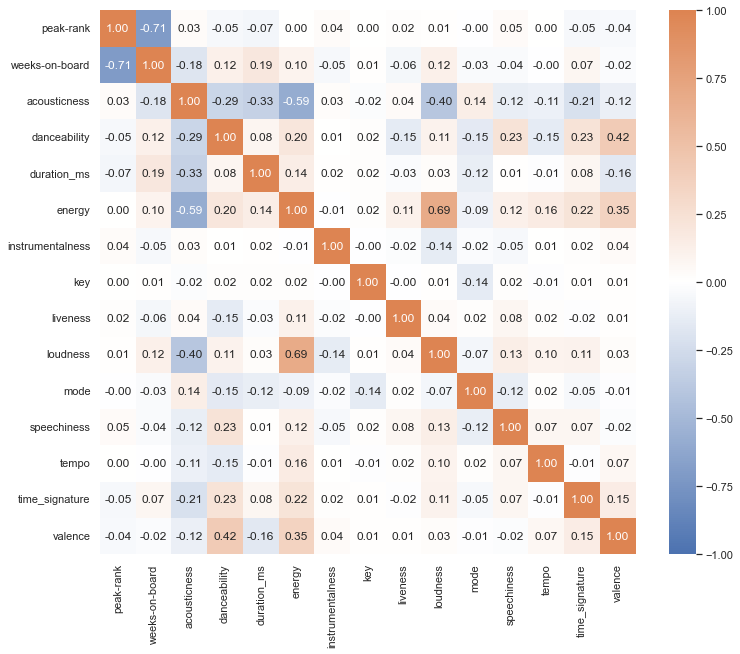

In [12]:
# correlation matrix - All Songs
corr_billboard_weeks = df_B100_SORTED.corr()

# plot
palette = sns.blend_palette([sns.color_palette()[0], '#ffffff', sns.color_palette()[1]], 3, as_cmap=True)
plt.subplots(figsize=(12, 10))
sns.heatmap(corr_billboard_weeks, cmap=palette, center=0, vmin=-1, vmax=1, annot=True, fmt='.2f')
title='Correlation of Billboard Rankings to Audio Features'
# plt.title(title, fontsize=13, pad=20)

# save the image
plt.savefig(f'figures/correlation/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

plt.show()

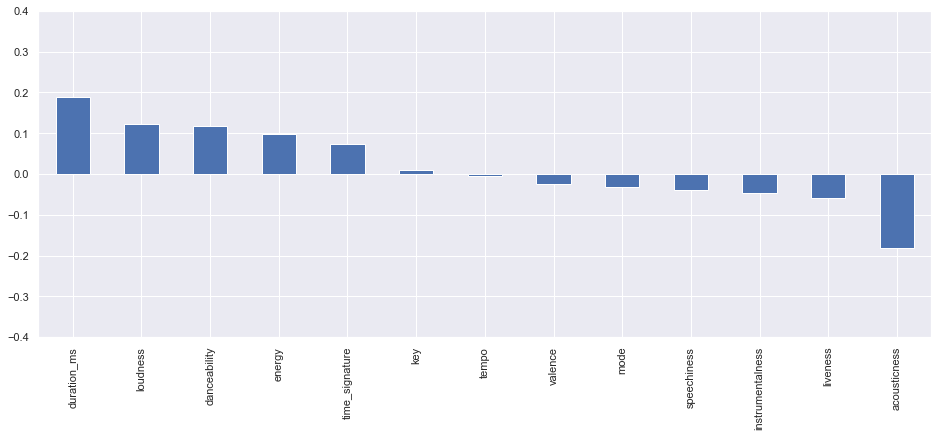

In [13]:
# correlated with weeks on board in Billboard Hot 100
corr_billboard_weeks['weeks-on-board'].sort_values(ascending=False)[1:-1].plot(kind='bar', figsize=(16,6))
title='Correlation of Weeks on Billboard Hot 100 vs Audio Features'
# plt.title(title, fontsize=13, pad=20)
plt.ylim(-0.4, 0.4)

# save the image
plt.savefig(f'figures/correlation/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

plt.show()

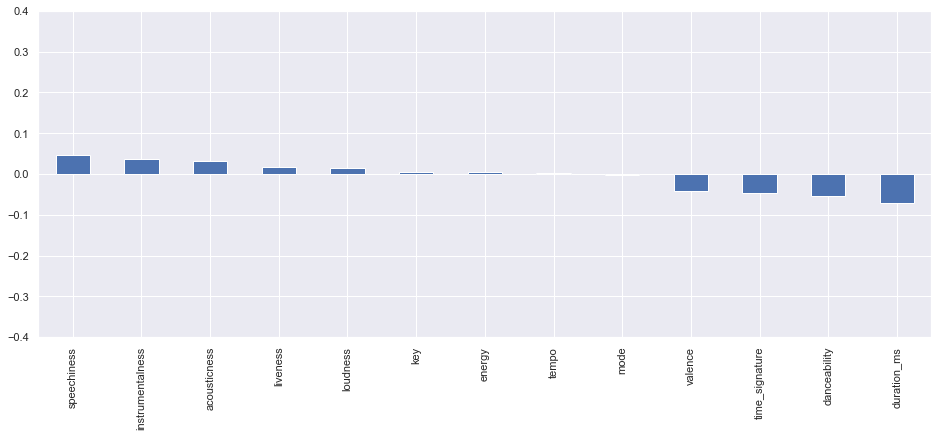

In [14]:
# correlated with peak rank in Billboard Hot 100
corr_billboard_weeks['peak-rank'].sort_values(ascending=False)[1:-1].plot(kind='bar', figsize=(16,6))
title='Correlation of Peak Rank on Billboard Hot 100 vs Audio Features'
# plt.title(title, fontsize=13, pad=20)
plt.ylim(-0.4, 0.4)

# save the image
plt.savefig(f'figures/correlation/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

plt.show()

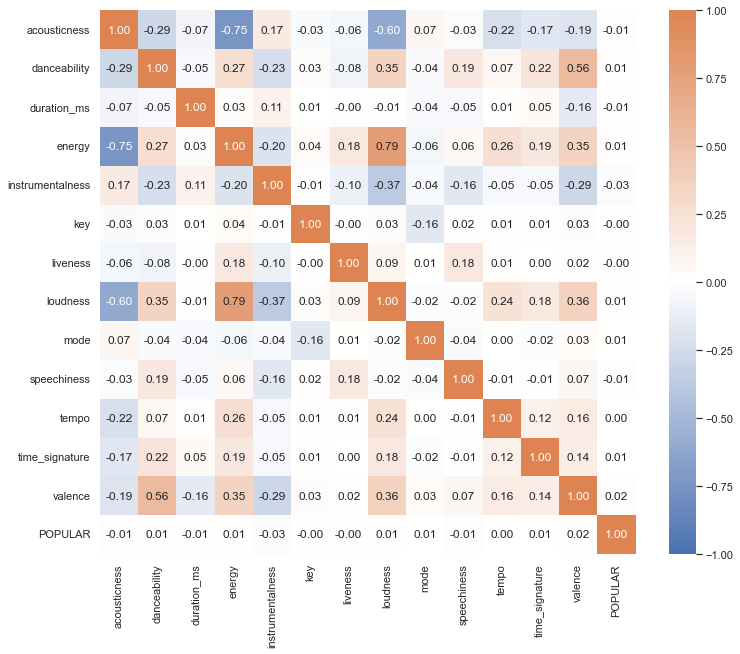

In [9]:
# correlation matrix - popular or not
# Note: "POPULAR" simply denotes whether or not a song appeared on the Billboard Hot 100
corr_popular = df_popularity.corr()

# plot
palette = sns.blend_palette([sns.color_palette()[0], '#ffffff', sns.color_palette()[1]], 3, as_cmap=True)
plt.subplots(figsize=(12, 10))
sns.heatmap(corr_popular, cmap=palette, center=0, vmin=-1, vmax=1, annot=True, fmt='.2f')
title='Correlation of Popularity with Audio Features'
# plt.title(title, fontsize=13, pad=20)

# save the image
plt.savefig(f'figures/correlation/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

plt.show()

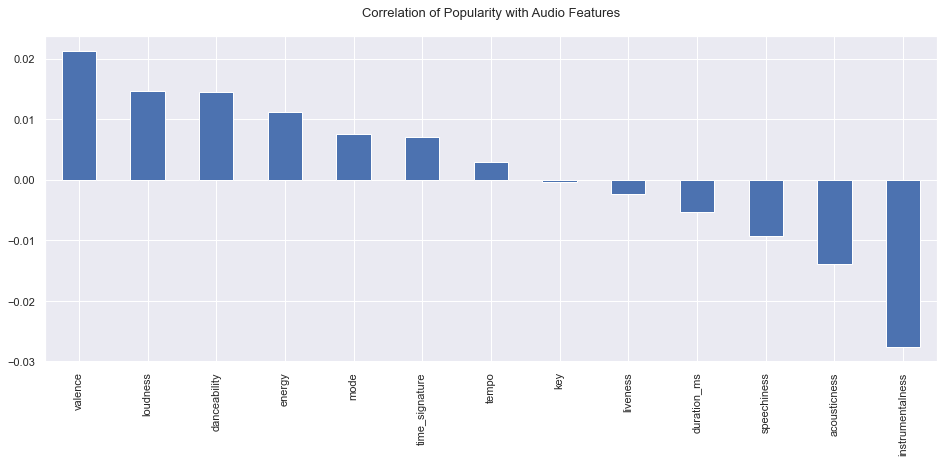

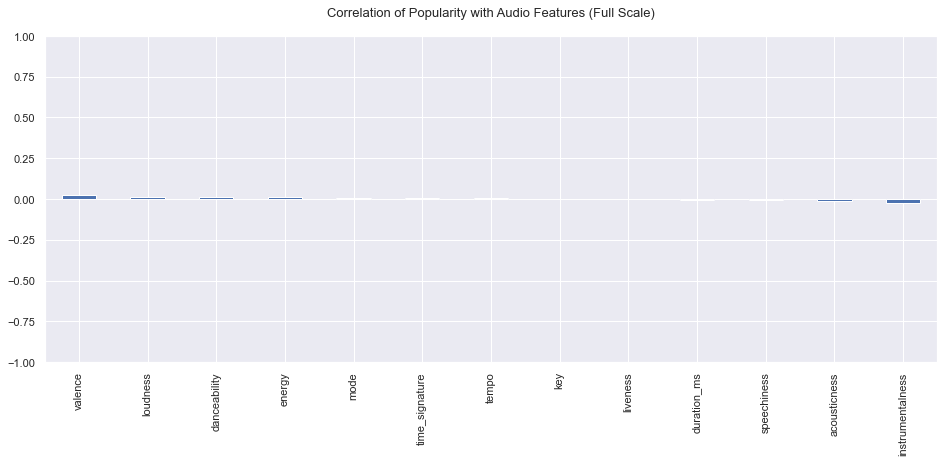

In [19]:
# correlated with peak rank in Billboard Hot 100
corr_popular['POPULAR'].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(16,6))
title='Correlation of Popularity with Audio Features'
plt.title(title, fontsize=13, pad=20)

# save the image
plt.savefig(f'figures/correlation/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

plt.show()

corr_popular['POPULAR'].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(16,6))
title='Correlation of Popularity with Audio Features (Full Scale)'
plt.title(title, fontsize=13, pad=20)
plt.ylim(-1, 1)

# save the image
plt.savefig(f'figures/correlation/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

plt.show()

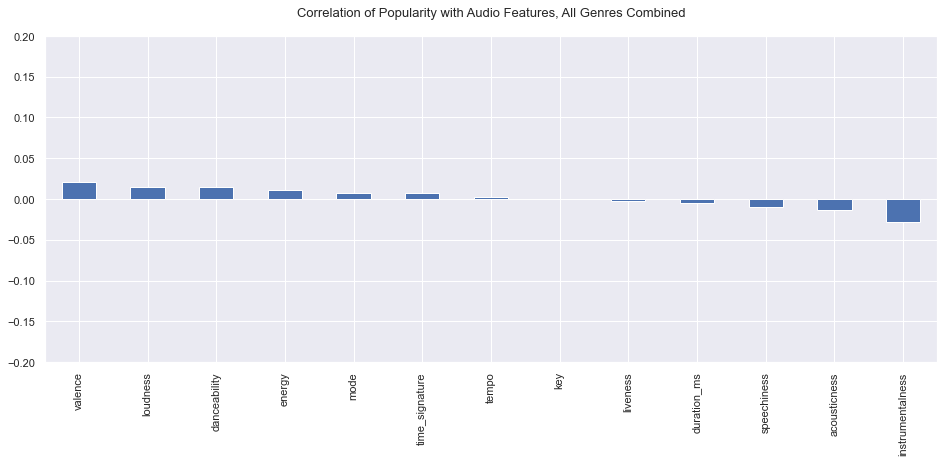

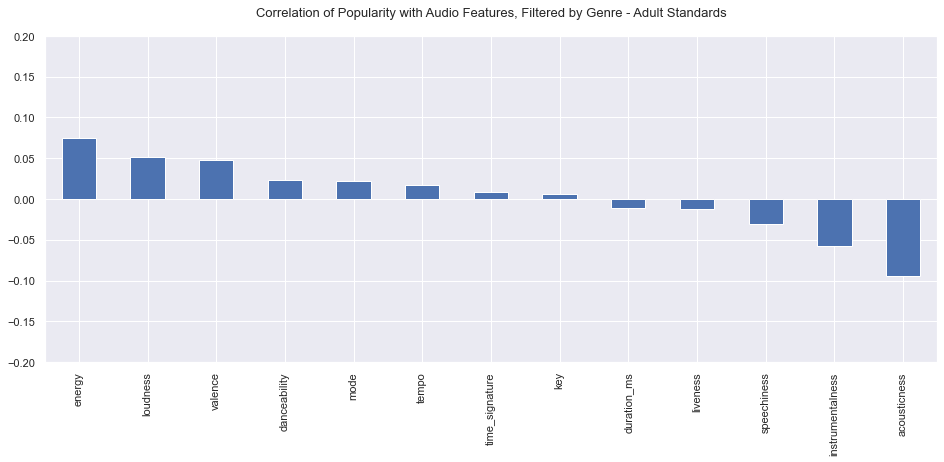

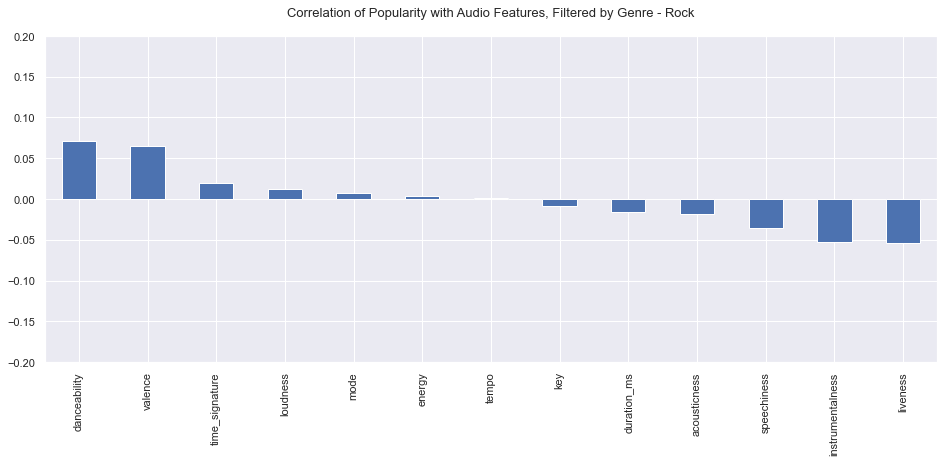

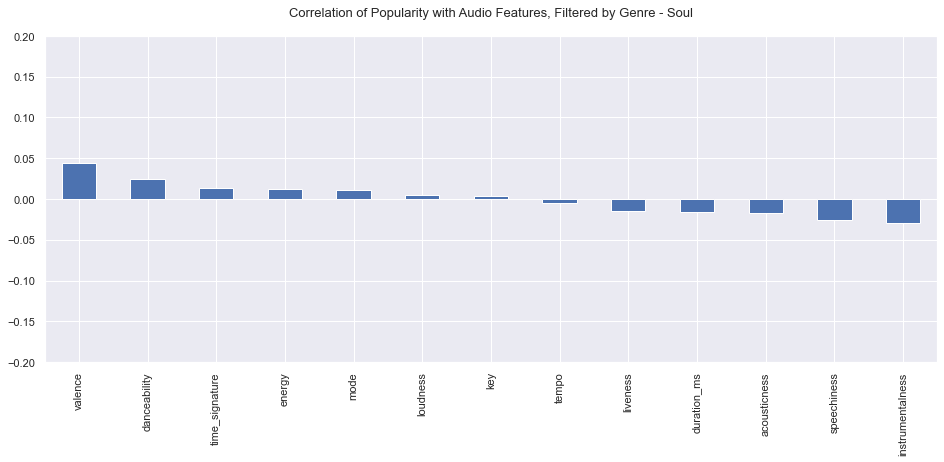

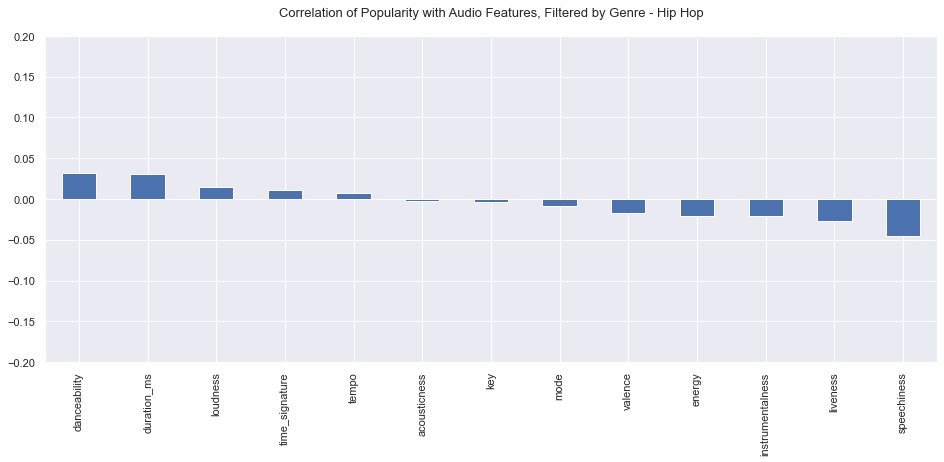

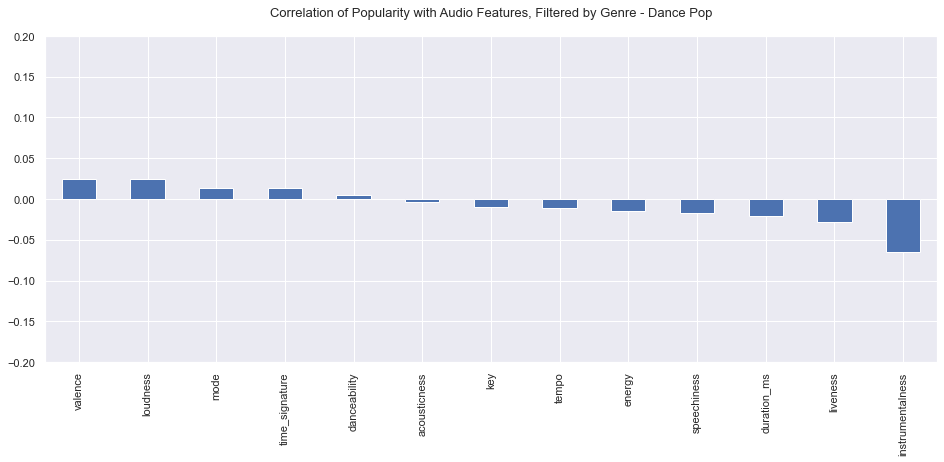

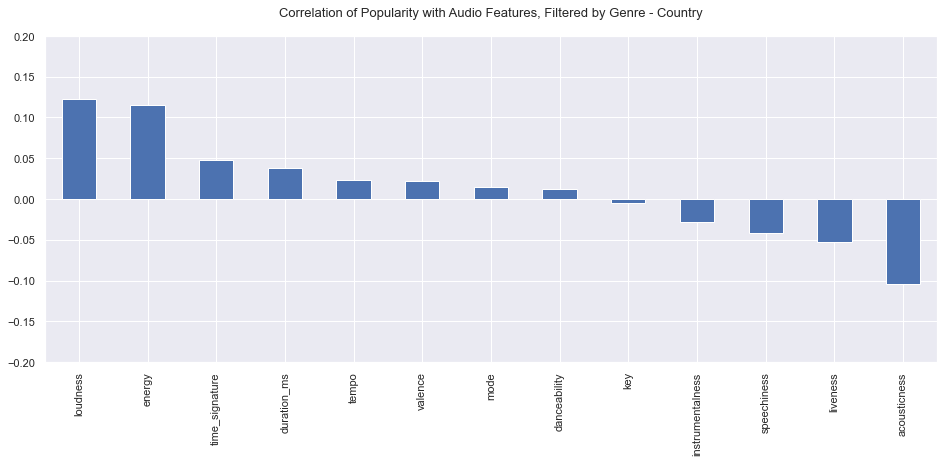

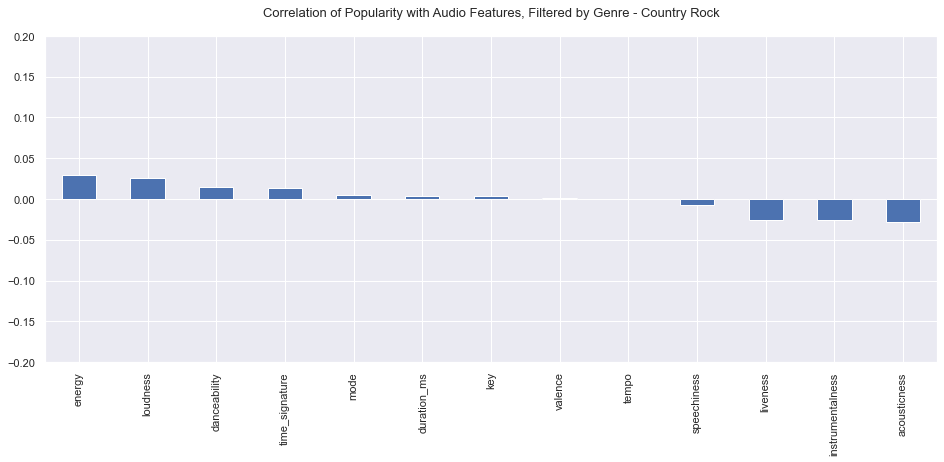

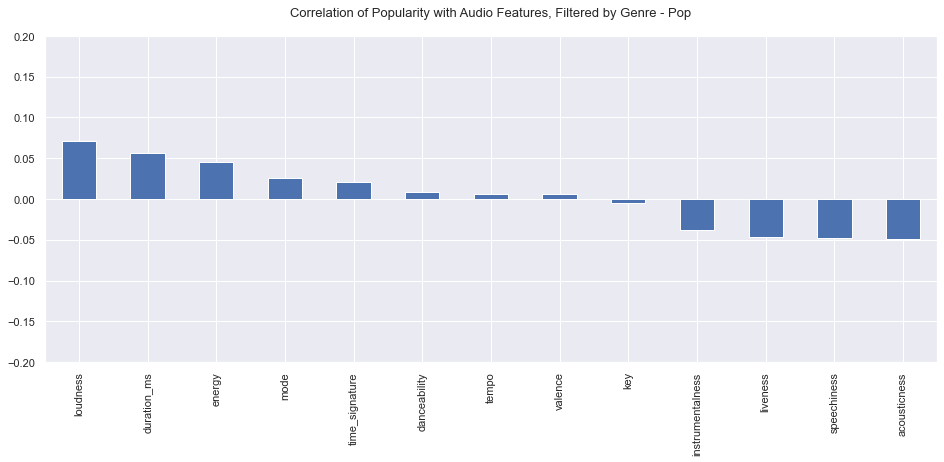

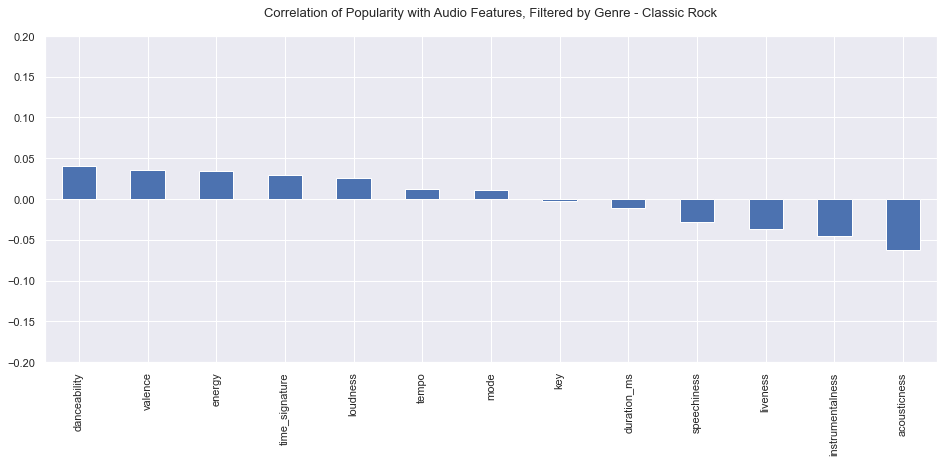

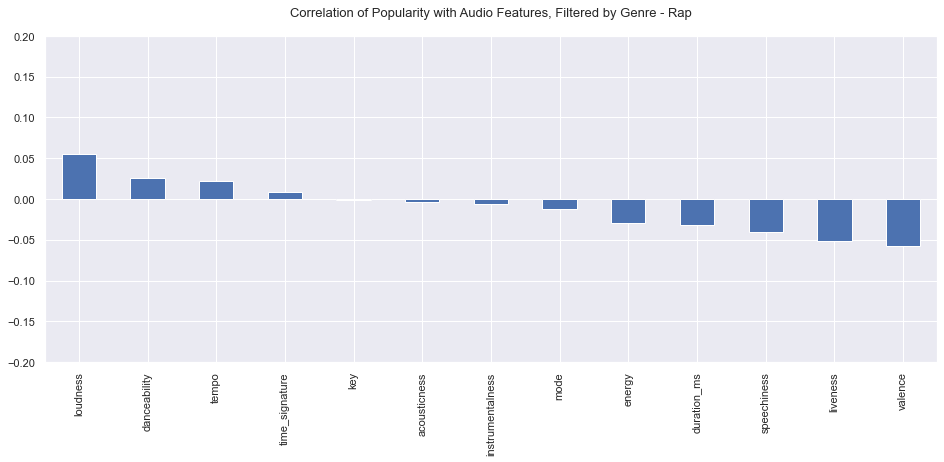

In [20]:
# top 10 genres in Billboard Hot 100
genres = list(df_B100_songs_AF.genre.value_counts().head(10).index)

# shared y limits
ylim = -0.2, 0.2

# all genres
df_popularity.corr()['POPULAR'].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(16,6))
title='Correlation of Popularity with Audio Features, All Genres Combined'
plt.title(title, fontsize=13, pad=20)
plt.ylim(*ylim)

# save the image
plt.savefig(f'figures/correlation/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

plt.show()

# separated genres
for genre in genres:
    df_popularity.query(f'genre == "{genre}"').corr()['POPULAR'].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(16,6))
    title = f'Correlation of Popularity with Audio Features, Filtered by Genre - {genre.title()}'
    plt.title(title, fontsize=13, pad=20)
    plt.ylim(*ylim)

    # save the image
    plt.savefig(f'figures/correlation/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')

    plt.show()

In [21]:
# testing with regex to look for ability to categorise more broadly

heavy_regex = df_popularity[df_popularity.genre.str.contains(r'(?:metal|heavy|hard|alternative)').fillna(False)]

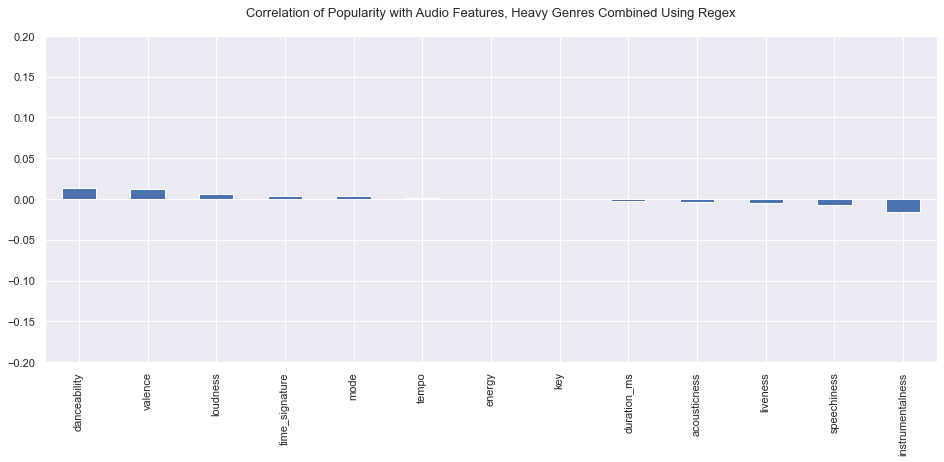

In [22]:
# shared y limits
ylim = -0.2, 0.2

# all genres
heavy_regex.corr()['POPULAR'].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(16,6))
title='Correlation of Popularity with Audio Features, Heavy Genres Combined Using Regex'
plt.title(title, fontsize=13, pad=20)
plt.ylim(*ylim)
plt.show()

In [23]:
# there is some interesting stuff here!
heavy_regex.genre.sample(10)

5142850                 hardcore
2797925         gothenburg metal
1817958            spanish metal
1974334       metal pernambucano
2652048         mexican hardcore
3123181      neo classical metal
1466484    brazilian death metal
3080051    nederlandse hardstyle
5429164         industrial metal
284091              metal gaucho
Name: genre, dtype: object

# Genres

### Import Genre Data

In [15]:
df_genre_counts.shape[0]

5489

In [78]:
# top 10 genres
df_genre_counts.head(10)

count
genre_id                      
classical               495467
classical performance   287065
adult standards         191882
rock                    136731
early music             127095
orchestral performance  119693
vocal jazz              117062
orchestra               113422
classic rock            109292
lounge                  108578

In [27]:
# 10 random genres
list(df_genre_counts.sample(10).index)

['rock alternativo brasileiro',
 'rap chretien',
 'marathi devotional',
 'power blues-rock',
 'swedish melodic rock',
 'deep smooth r&b',
 'flamenco urbano',
 'art rock',
 'psicodelia brasileira',
 'gothic americana']

### Too Many Genres!!!

* genre_id seems more like a subgenre than an overarching genre
* it may be worth grouping these subgenres into broader genres

### Regex Filtering to Create Subgenre Groups

##### Test Case 1: Heavy Music (not popular on Billboard Charts)

In [34]:
regex_heavy = r'(?:metal|heavy|hard|alternative)'

heavy_genre_counts = df_popularity[df_popularity.genre.str.contains(regex_heavy).fillna(False)].groupby('genre').count()['id'].sort_values(ascending=False)

In [41]:
# what about on the Billboard Hot 100?
df_B100_songs_AF[df_B100_songs_AF.genre.str.contains(regex_heavy).fillna(False)].groupby('genre').count()['id'].sort_values(ascending=False).head()

genre
alternative metal      129
hard rock               30
alternative rock         8
hardcore hip hop         8
alternative hip hop      4
Name: id, dtype: int64

In [186]:
# alternative metal is most popular, let's take a look at the top 10 alt metal bands in the Billboard Hot 100
df_B100_songs_AF[df_B100_songs_AF.genre.str.contains('^alternative metal?')].groupby('artist').count()['id'].sort_values(ascending=False).head(10)

artist
Linkin Park          19
Nickelback           18
Three Days Grace      7
Shinedown             7
Breaking Benjamin     6
Seether               6
Disturbed             6
Papa Roach            6
Good Charlotte        6
Limp Bizkit           5
Name: id, dtype: int64

In [56]:
# let's compare to the heavy regex category
df_B100_songs_AF[df_B100_songs_AF.genre.str.contains(regex_heavy)].groupby('artist').count()['id'].sort_values(ascending=False).head(10)

# same bands, slightly different sorting

artist
Linkin Park          19
Nickelback           18
Three Days Grace      7
Shinedown             7
Seether               6
Breaking Benjamin     6
Papa Roach            6
Good Charlotte        6
Disturbed             6
Limp Bizkit           5
Name: id, dtype: int64

In [55]:
# even though the top 10 is the same, many less popular bands are missed
(df_B100_songs_AF[df_B100_songs_AF.genre.str.contains('alternative metal')].groupby('artist').count()['id'].shape[0], 
df_B100_songs_AF[df_B100_songs_AF.genre.str.contains(regex_heavy)].groupby('artist').count()['id'].shape[0])

(35, 86)

In [67]:
# let's take a look - every heavy song on the Billboard charts that isn't "alternative metal"
df_B100_songs_AF[
    (df_B100_songs_AF.genre.str.contains(regex_heavy)) & (df_B100_songs_AF.genre != 'alternative metal')
].sort_values('release_date')[['artist', 'song', 'release_date', 'genre']]

# not a lot of data to work with, probably shouldn't use this genre
# lets see if this improves specificity for audio features

artist                                       song  \
17765             The Raiders                             Just Seventeen   
6584             Gene Simmons                                Radioactive   
11954                Mistress                            Mistrusted Love   
6759                 Giuffria                          Call To The Heart   
6761                 Giuffria                             Lonely In Love   
6760                 Giuffria                         I Must Be Dreaming   
15566                 Stryper                       Always There For You   
2570               Britny Fox                           Long Way To Love   
19339                   Vixen                                     Cryin'   
19340                   Vixen                     Edge Of A Broken Heart   
15568                 Stryper                           I Believe In You   
16542              The Church                        Under The Milky Way   
2774               BulletBoys                      For The Love Of Money   
2775               BulletBoys                                  Smooth Up   
15827                 Tangier                                On The Line   
14704                  Saraya                         Back To The Bullet   
14705                  Saraya                    Love Has Taken Its Toll   
18883               Tora Tora                              Walkin' Shoes   
5662             Enuff Z'Nuff                                  New Thing   
11549  McAuley Schenker Group                                    Anytime   
19342                   Vixen                           Love Is A Killer   
10686           Little Caesar                             Chain Of Fools   
19077                 Trixter                           One In A Million   
10687           Little Caesar                               In Your Arms   
19078                 Trixter                                  Surrender   
19076                 Trixter                         Give It To Me Good   
19341                   Vixen                              How Much Love   
12382                  Nelson                             More Than Ever   
12383                  Nelson                        Only Time Will Tell   
12381                  Nelson                             After The Rain   
9519             Kane Roberts  Does Anybody Really Fall In Love Anymore?   
11956            Mitch Malloy                    Nobody Wins In This War   
11067                MC Serch                              Here It Comes   
11955            Mitch Malloy                            Anything At All   
14526             Saigon Kick                         Love Is On The Way   
1437                    Belly                              Feed The Tree   
7146              Green Jelly                          Three Little Pigs   
11548              Mazzy Star                              Fade Into You   
3972            Da Youngsta's                               Hip Hop Ride   
6378          Freedy Johnston                             Bad Reputation   
5365                 Elastica                                    Stutter   
3112             Channel Live                                    Mad Izm   
9348         Juliana Hatfield                       Universal Heart-Beat   
5364                 Elastica                                 Connection   
17800             The Rentals                              Friends Of P.   
7342               Heather B.                                     Do You   
14509                 Sadat X                              Hang 'Em High   
7614                    Ideal                                   Get Gone   
5847                  FRENTE!                      Bizarre Love Triangle   
7084                 Gorillaz                             Clint Eastwood   
19642            X-Ecutioners                            It's Goin' Down   
15567                 Stryper                                   Honestl

### Boxplots

In [16]:
# helper function with variable number of dataframes would be useful to compare more data

def boxplot_genre_comparison(dataframe, genre_dict, title, figsize=(20,10), showfliers=False):

    boxplot_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']
    plt.figure(figsize=figsize)

    list_of_genre_df = []
    
    for genre in genre_dict:
        list_of_genre_df.append(dataframe[dataframe.genre.str.contains(genre_dict[genre]).fillna(False)][boxplot_features].assign(genre_name=genre))
    
    sns.boxplot(pd.melt(pd.concat(list_of_genre_df), id_vars=['genre_name']), x='variable', y='value', hue='genre_name', showfliers=showfliers)
#     plt.title(title, fontsize=13, pad=10)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    # save the figure
    plt.savefig(f'figures/genres/{title}.png', facecolor='w', dpi=150, bbox_inches='tight')
    
    plt.show()


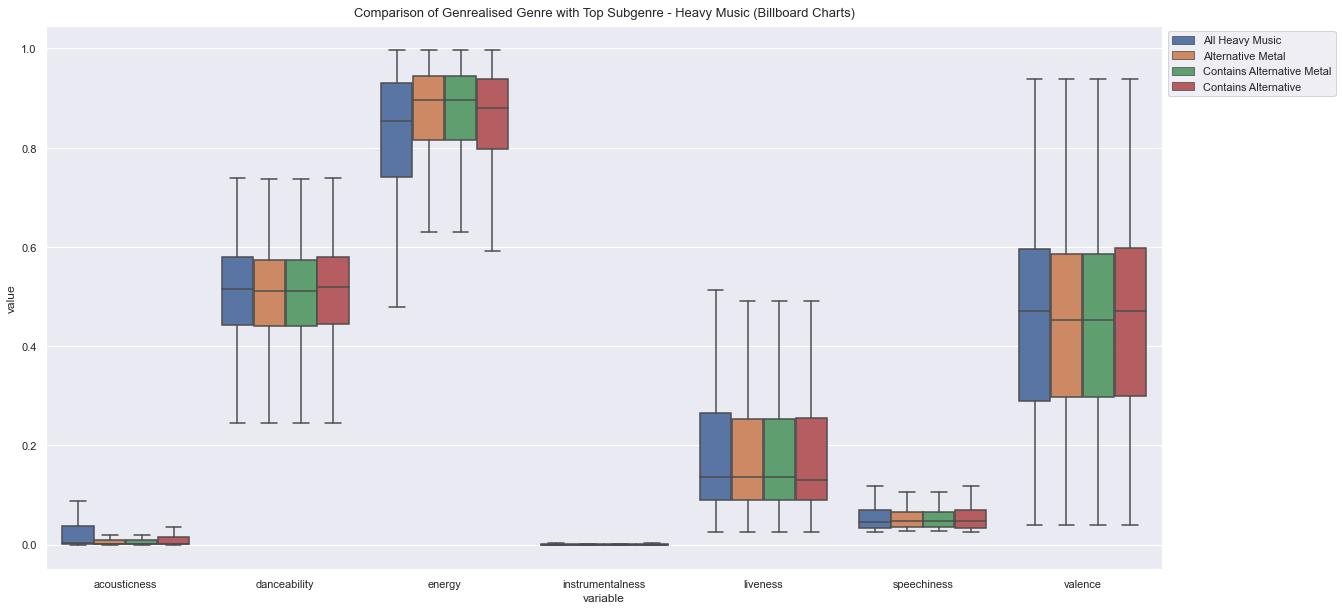

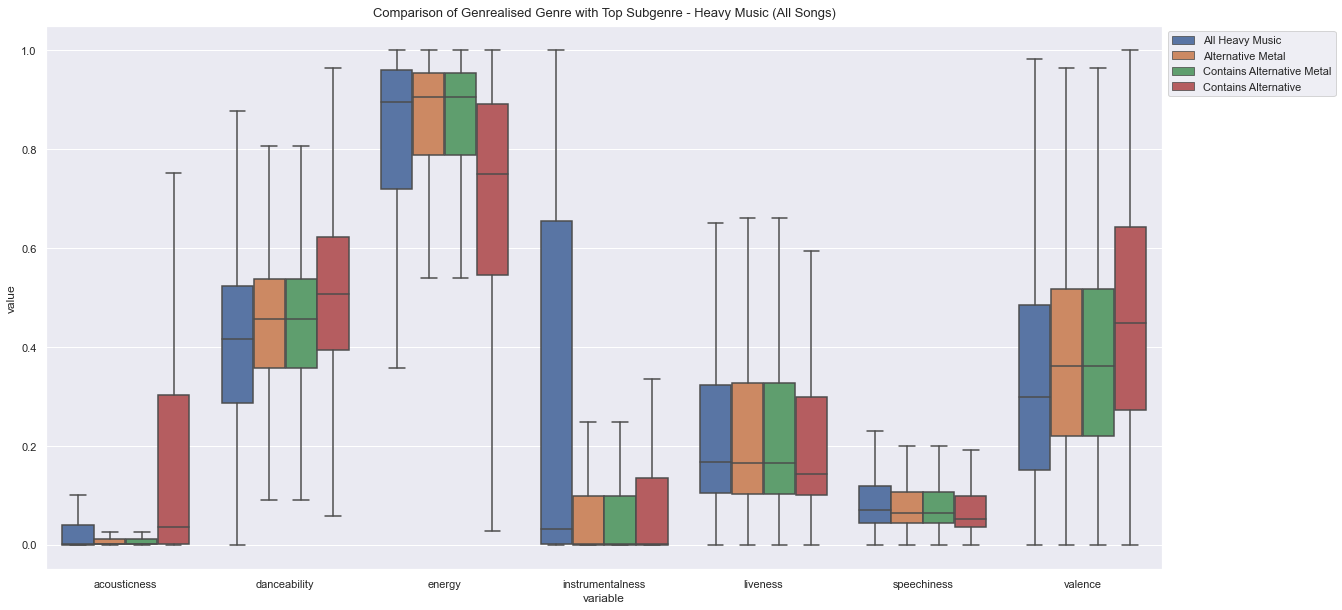

In [58]:
genre_dict = {
    'All Heavy Music': r'(?:metal|heavy|hard|alternative)', 
    'Alternative Metal': '^alternative metal?',
    'Contains Alternative Metal': 'alternative metal',
    'Contains Alternative': 'alternative',
}

title = 'Comparison of Genrealised Genre with Top Subgenre - Heavy Music ({})'

boxplot_genre_comparison(df_B100_songs_AF, genre_dict, title.format('Billboard Charts'))
boxplot_genre_comparison(df_10M, genre_dict, title.format('All Songs'))

##### Conclusion: It looks like adding more genrealised genre data increases variability

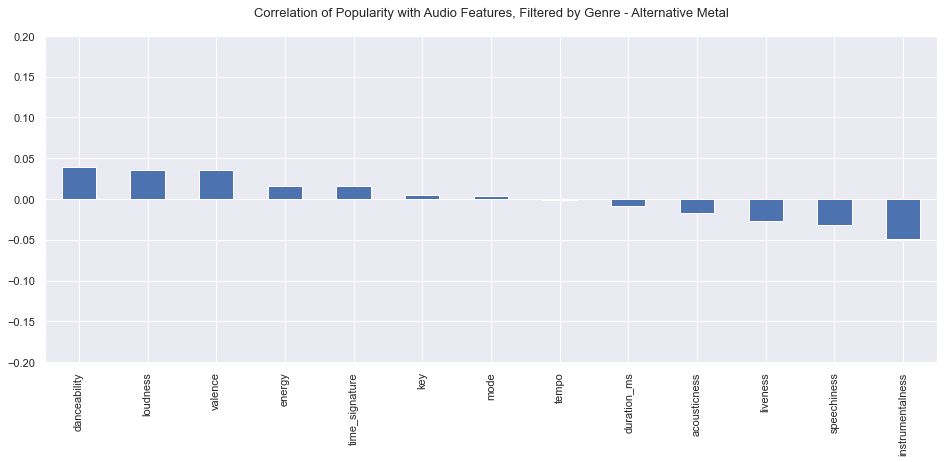

In [162]:
# let's see if "alternative metal is any better behaved than heavy music in general"

genre = 'alternative metal'

df_popularity.query(f'genre == "{genre}"').corr()['POPULAR'].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(16,6))
title = f'Correlation of Popularity with Audio Features, Filtered by Genre - {genre.title()}'
plt.title(title, fontsize=13, pad=20)
plt.ylim(*ylim)

plt.show()

* This looks a little better, not as strong as some genres, and weak correlation overall
* It may be difficult to make any popularity predictions using these features for this genre
* Interesting non-intuitive results. Popular Alternative Metal is:
    * Billboard charts have more consistent songs (not surprising)
    * danceable
    * loud (not surprising)
    * happier than typically in the genre (positively correlated with higher valence)
    * lower instrumentalness correlated with higher "popularity" 

##### Test Case 2: Pop Music

In [135]:
regex_pop = r'(?:pop|adult standards|contemporary)'

# top 10 regex_pop genres (all songs)
df_popularity[df_popularity.genre.str.contains(regex_pop).fillna(False)].groupby('genre').count()['id'].sort_values(ascending=False).head(10)

genre
adult standards      185851
dance pop             36147
c-pop                 19507
pop rock              19077
pop rap               17152
afropop               16285
italian adult pop     14738
europop               14027
new wave pop          13324
russian pop           12319
Name: id, dtype: int64

In [138]:
# top 10 regex_pop genres (billboard)
df_B100_songs_AF[df_B100_songs_AF.genre.str.contains(regex_pop).fillna(False)].groupby('genre').count()['id'].sort_values(ascending=False).head(10)

genre
adult standards         3339
dance pop               1172
pop                      481
pop rock                 415
pop rap                  389
brill building pop       384
new wave pop             227
post-teen pop            187
bubblegum pop            126
deep adult standards     102
Name: id, dtype: int64

In [134]:
# confirming that "adult standards" are indeed Pop Music - looks like it to me!
df_B100_songs_AF.query('genre == "adult standards"').artist.sample(10)

2357           Boz Scaggs
14564           Sam Cooke
17070         The Hollies
1074          B.J. Thomas
4286          Dean Martin
1294     Barbra Streisand
14760      Seals & Crofts
15520       Stevie Wonder
9049        Johnny Mathis
7875        Jackie Wilson
Name: artist, dtype: object

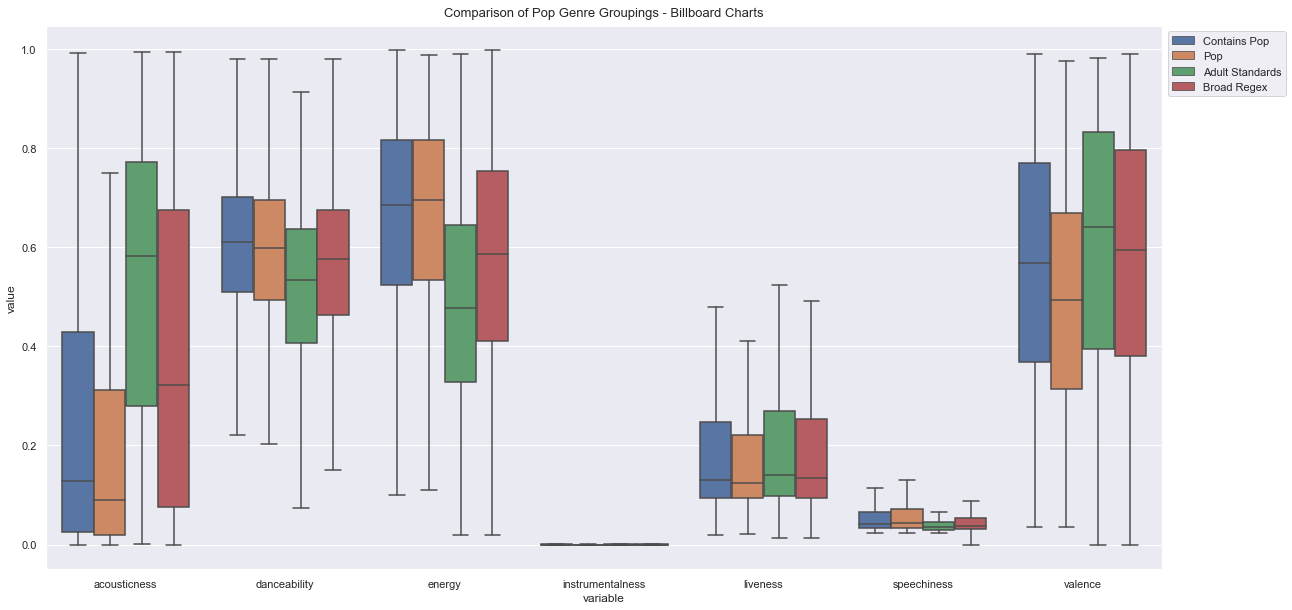

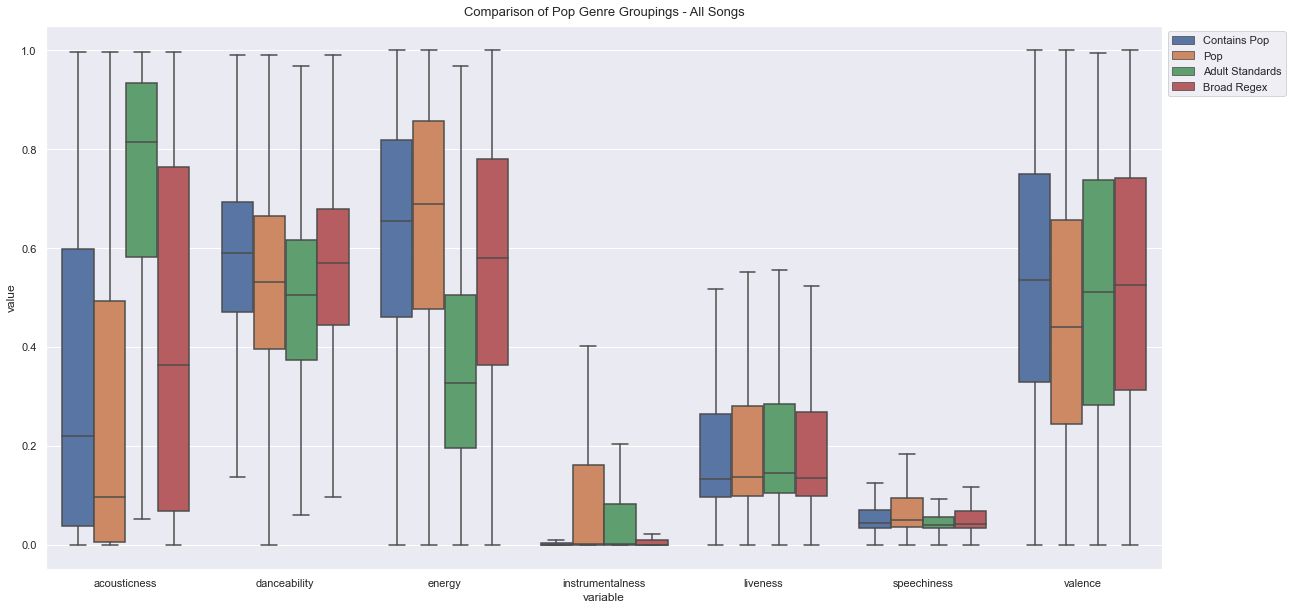

In [59]:
# boxplot comparison of Pop genres

genre_dict = {
    'Contains Pop': r'pop',
    'Pop': r'^pop?',
    'Adult Standards': r'^adult standards?',
    'Broad Regex':  r'(?:pop|adult standards|contemporary)'
}

title = 'Comparison of Pop Genre Groupings - {}'

boxplot_genre_comparison(df_B100_songs_AF, genre_dict, title.format('Billboard Charts'))
boxplot_genre_comparison(df_10M, genre_dict, title.format('All Songs'))

### Boxplots for Large Genre Groups

In [52]:
# df_B100_songs_AF.groupby('genre').count()['id'].sort_values(ascending=False).head(50)

In [18]:
# approximating genre categories
genre_dict = {
    'All Songs': r'.+', 
    'Adult Standards': r'(?:adult standards|mellow gold|soft rock|contemporary)',
    'Rock': r'(?:rock|^country|^soft)',
    'R&B':  r'(?:soul|rhythm and blues|motown|funk|disco|quiet storm)',  # this one is a stretch
    'Country': r'(?:country|folk|nashville sound)',
    'Pop': r'\b(?:pop|europop)\b',  # whole word only
    'Rap': r'\b(?:rap|trap|hip hop)\b',  # whole word only
    'Alternative': r'(?:alternative)',  # not sure if grunge or punk should be here
    'EDM': r'(?:house|trance|techno|drum and bass|dubstep|synth|edm|breakbeat)', # not very popular on Bilboard
    'Metal': r'(?:heavy|metal|thrash|djent|deathcore|mathcore|grindcore)' # not very popular on Bilboard
}

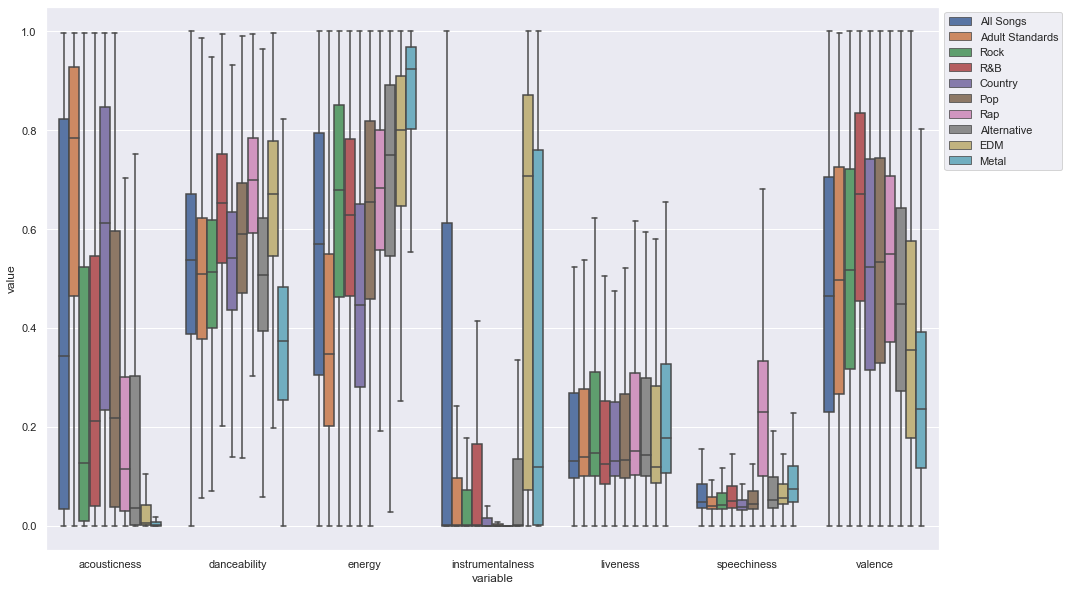

In [20]:
# plot it
title = 'Comparison of Audio Featuers for Large Genre Groupings (as defined by Kevin) - {}'
figsize = (16, 10)
# boxplot_genre_comparison(df_B100_songs_AF, genre_dict, title.format('Billboard Charts'), figsize=figsize)
boxplot_genre_comparison(df_10M, genre_dict, title.format('All Songs'), figsize=figsize)

In [125]:
# genre statistics vs relative popularity

df_genres = pd.DataFrame()

for genre in list(genre_dict.keys()):
    df_genres.loc[genre, 'billboard_counts'] = df_B100_songs_AF[(df_B100_songs_AF.genre.str.contains(genre_dict[genre])).fillna(False)].count()['id']
    df_genres.loc[genre, 'all_counts'] = df_10M[(df_10M.genre.str.contains(genre_dict[genre])).fillna(False)].count()['id']


In [147]:
# new columns
df_genres['proportion_billboard'] = df_genres['billboard_counts'] / df_genres['billboard_counts'].sum()
df_genres['proportion_allsongs'] = df_genres['all_counts'] / df_genres['all_counts'].sum()
df_genres['relative_popularity'] = df_genres['proportion_billboard'] / df_genres['proportion_allsongs']
df_genres['songs_per_popular_song'] = df_genres['all_counts'] / df_genres['billboard_counts']

# transpose and format
dft = df_genres.T
dft.iloc[0:2] = dft.iloc[0:2].applymap('{0:,.0f}'.format)
dft.iloc[2:-1] = dft.iloc[2:-1].applymap('{0:,.3f}'.format)
dft.iloc[-1:] = dft.iloc[-1:].applymap('{0:,.0f}'.format)
dft

Adult Standards     Rock      R&B  Country      Pop  \
billboard_counts                 4,313    6,457    2,594    2,268    3,784   
all_counts                     234,547  727,276  157,511  283,317  600,693   
proportion_billboard             0.195    0.293    0.118    0.103    0.171   
proportion_allsongs              0.076    0.236    0.051    0.092    0.195   
relative_popularity              2.572    1.242    2.303    1.120    0.881   
songs_per_popular_song              54      113       61      125      159   

                            Rap Alternative      EDM    Metal  
billboard_counts          2,269         148      101      140  
all_counts              454,944      89,355  271,306  268,320  
proportion_billboard      0.103       0.007    0.005    0.006  
proportion_allsongs       0.147       0.029    0.088    0.087  
relative_popularity       0.698       0.232    0.052    0.073  
songs_per_popular_song      201         604    2,686    1,917

In [154]:
# best genres to write music in if you want onto the Billboad Hot 100
print('Total Songs in each Genre per Song on the Billboard Hot 100')
print(df_genres['songs_per_popular_song'].astype('int32').sort_values())

Total Songs in each Genre per Song on the Billboard Hot 100
Adult Standards      54
R&B                  60
Rock                112
Country             124
Pop                 158
Rap                 200
Alternative         603
Metal              1916
EDM                2686
Name: songs_per_popular_song, dtype: int32
